In [3]:
import warnings
warnings.filterwarnings('ignore')

### Dataset Sources

Beat Acute Myeloid Leukemia (AML) 1.0 was accessed on 13Mar2023 from https://registry.opendata.aws/beataml. OHSU BeatAML Datasets Link: https://ctd2-data.nci.nih.gov/Public/OHSU-1/BeatAML_Waves1_2/

OpenCell Datasets Link: https://opencell.czbiohub.org/download

### Check Pre-Requisites from the `01_setup/` Folder

In [4]:
%store -r setup_instance_check_passed

In [5]:
try:
    setup_instance_check_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++")

In [6]:
print(setup_instance_check_passed)

True


In [7]:
%store -r setup_dependencies_passed

In [8]:
try:
    setup_dependencies_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++")

In [9]:
print(setup_dependencies_passed)

True


In [10]:
%store -r setup_s3_bucket_passed

In [11]:
try:
    setup_s3_bucket_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++")

In [12]:
print(setup_s3_bucket_passed)

True


In [13]:
%store -r setup_iam_roles_passed

In [14]:
try:
    setup_iam_roles_passed
except NameError:
    print("+++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++")

In [15]:
print(setup_iam_roles_passed)

True


In [16]:
if not setup_instance_check_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Instance Check.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_dependencies_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup Dependencies.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_s3_bucket_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup S3 Bucket.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
if not setup_iam_roles_passed:
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOU HAVE TO RUN ALL NOTEBOOKS IN THE SETUP FOLDER FIRST. You are missing Setup IAM Roles.")
    print("+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")

In [17]:
import boto3
import sagemaker
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
account_id = boto3.client("sts").get_caller_identity().get("Account")

sm = boto3.Session().client(service_name="sagemaker", region_name=region)

# S3 Original Dataset Location

Importing Raw Datasets from AWS S3. Use the AWS Command Line Interface (CLI) to list the S3 bucket content using the following CLI commands:

In [18]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/

2023-03-21 02:37:21          0 
2023-03-27 02:40:07     714614 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.txt


In [19]:
!aws s3 ls s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


### Set S3 Source Location

In [20]:
#BeatAML Clinical Summary
s3_public_path_clsm = "s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/"

In [21]:
%store s3_public_path_clsm

Stored 's3_public_path_clsm' (str)


In [22]:
print(s3_public_path_clsm)

s3://team4rawdatasets/CSV/Input/OHSU_BeatAML_ClinicalSummary/


In [23]:
!aws s3 ls $s3_public_path_clsm

2023-03-21 02:37:21          0 
2023-03-27 02:40:07     714614 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.txt


In [24]:
#BeatAML OpenCell Protein Interaction
s3_public_path_pi = "s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/"

In [25]:
%store s3_public_path_pi

Stored 's3_public_path_pi' (str)


In [26]:
print(s3_public_path_pi)

s3://team4rawdatasets/CSV/Input/OpenCell_ProteinInteraction/


In [27]:
!aws s3 ls $s3_public_path_pi

2023-03-21 02:37:38          0 
2023-03-21 02:38:40    4568928 opencell-protein-interactions.csv


In [28]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?prefix=CSV/Input/&region=us-east-1">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# Athena

### Athena Database

[PyAthena](https://pypi.org/project/PyAthena/) is a Python DB API 2.0 (PEP 249) compliant client for Amazon Athena.

In [29]:
!pip install --disable-pip-version-check -q PyAthena==2.1.0
from pyathena import connect

In [30]:
ingest_create_athena_db_passed = False

In [31]:
database_name = "bcr"

In [32]:
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)

In [33]:
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [34]:
statement0 = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement0)

CREATE DATABASE IF NOT EXISTS bcr


In [35]:
pd.read_sql(statement0, conn)

""


### Verify The Database Has Been Created Succesfully

In [36]:
statement00 = "SHOW DATABASES"

df_show = pd.read_sql(statement00, conn)
df_show.head(5)

,database_name
0,bcr
1,default
2,dsoaws
3,sagemaker_featurestore


In [37]:
if database_name in df_show.values:
    ingest_create_athena_db_passed = True

In [38]:
%store ingest_create_athena_db_passed

Stored 'ingest_create_athena_db_passed' (bool)


### Athena Table Created Through AWS Glue Crawler

In [39]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="top" href="https://us-east-1.console.aws.amazon.com/glue/home?region=us-east-1#/v2/data-catalog/tables">AWS Glue Catalog</a></b>'.format(
            region
        )
    )
)

### Athena Sample Query

In [40]:
# Set Athena database & table
table_clsm = "ohsu_beataml_clinicalsummary"
table_pi = "opencell_proteininteraction"

In [41]:
#Athena SQL Code
statement1 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_pi
)

print(statement1)


SELECT *
FROM bcr.opencell_proteininteraction 



In [42]:
pi = pd.read_sql(statement1, conn)
pi.head(5)

,target_gene_name,interactor_gene_name,target_ensg_id,interactor_ensg_id,interactor_uniprot_ids,pval,enrichment,interaction_stoichiometry,abundance_stoichiometry
0,CAPZB,LIN7C,ENSG00000077549,ENSG00000148943,Q9NUP9;G3V1D4,4.889967,1.542113,0.00026944917484596,0.324711286926561
1,CAPZB,LMO7,ENSG00000077549,ENSG00000136153,Q8WWI1-3;Q8WWI1;Q8WWI1-2;Q8WWI1-4;J3KP06;F8WD2...,2.665285,1.182825,0.000111619690128354,0.00988961909015504
2,CAPZB,LONP1,ENSG00000077549,ENSG00000196365,K7EJE8;K7EKE6;P36776-3;P36776-2;P36776;K7ER27,4.957110,1.578867,5.13961933660357e-05,0.366471912570298
3,CAPZB,LRCH2,ENSG00000077549,ENSG00000130224,Q5VUJ6-2;Q5VUJ6,8.604282,2.060498,0.000525813669431608,0.0341400849244183
4,CAPZB,LRPPRC,ENSG00000077549,ENSG00000138095,P42704;C9JCA9;B8ZZ38;A0A0C4DG06;H7C3W8,3.376001,1.100256,9.38744177157481e-05,1.9509501294781


In [43]:
if not pi.empty:
    print("[OK]")
else:
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR] YOUR DATA HAS NOT BEEN CONVERTED TO PARQUET. LOOK IN PREVIOUS CELLS TO FIND THE ISSUE.")
    print("++++++++++++++++++++++++++++++++++++++++++++++++++++++")

[OK]


# Data cleaning

### Import Tools: 

In [44]:
!pip install klib


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [45]:
import numpy as np
import seaborn as sns
import klib
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## BeatAML Clinical Summary

### OHSU BeatAML Clinical Summary Table

In [46]:
# SQL statement
statement2 = """
SELECT *
FROM {}.{} 
""".format(
    database_name, table_clsm
)

print(statement2)


SELECT *
FROM bcr.ohsu_beataml_clinicalsummary 



In [47]:
clsm = pd.read_sql(statement2, conn)
clsm.head(5)

,labid,patientid,consensus_sex,inferred_sex,inferred_ethnicity,centerid,cebpa_biallelic,ageatdiagnosis,isrelapse,isdenovo,...,stag2,stat3,suz12,tcl1a,tet2,tp53,tyk2,u2af1,wt1,zrsr2
0,09-00705,163,Male,Male,White,1,n,73.0,False,True,...,,,,,,,,,,
1,10-00136,174,Male,Male,White,1,n,69.0,False,True,...,,,,,,,,,,
2,10-00172,175,Female,Male,White,1,n,59.0,False,True,...,,,,,,,,,,
3,10-00507,45,Female,Female,White,1,n,70.0,False,True,...,,,,,,,,,,
4,10-00542,174,Male,Male,White,1,n,69.0,True,False,...,,,,,,,,,,


In [48]:
clsm = clsm.replace('', np.NAN)
clsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Columns: 159 entries, labid to zrsr2
dtypes: bool(9), float64(22), int64(7), object(121)
memory usage: 793.5+ KB


In [49]:
clsm.info(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 159 columns):
 #    Column                                         Dtype  
---   ------                                         -----  
 0    labid                                          object 
 1    patientid                                      int64  
 2    consensus_sex                                  object 
 3    inferred_sex                                   object 
 4    inferred_ethnicity                             object 
 5    centerid                                       int64  
 6    cebpa_biallelic                                object 
 7    ageatdiagnosis                                 float64
 8    isrelapse                                      bool   
 9    isdenovo                                       bool   
 10   istransformed                                  bool   
 11   finalfusion                                    object 
 12   specificdxatacquisition_mdsmpn    

GridSpec(6, 6)

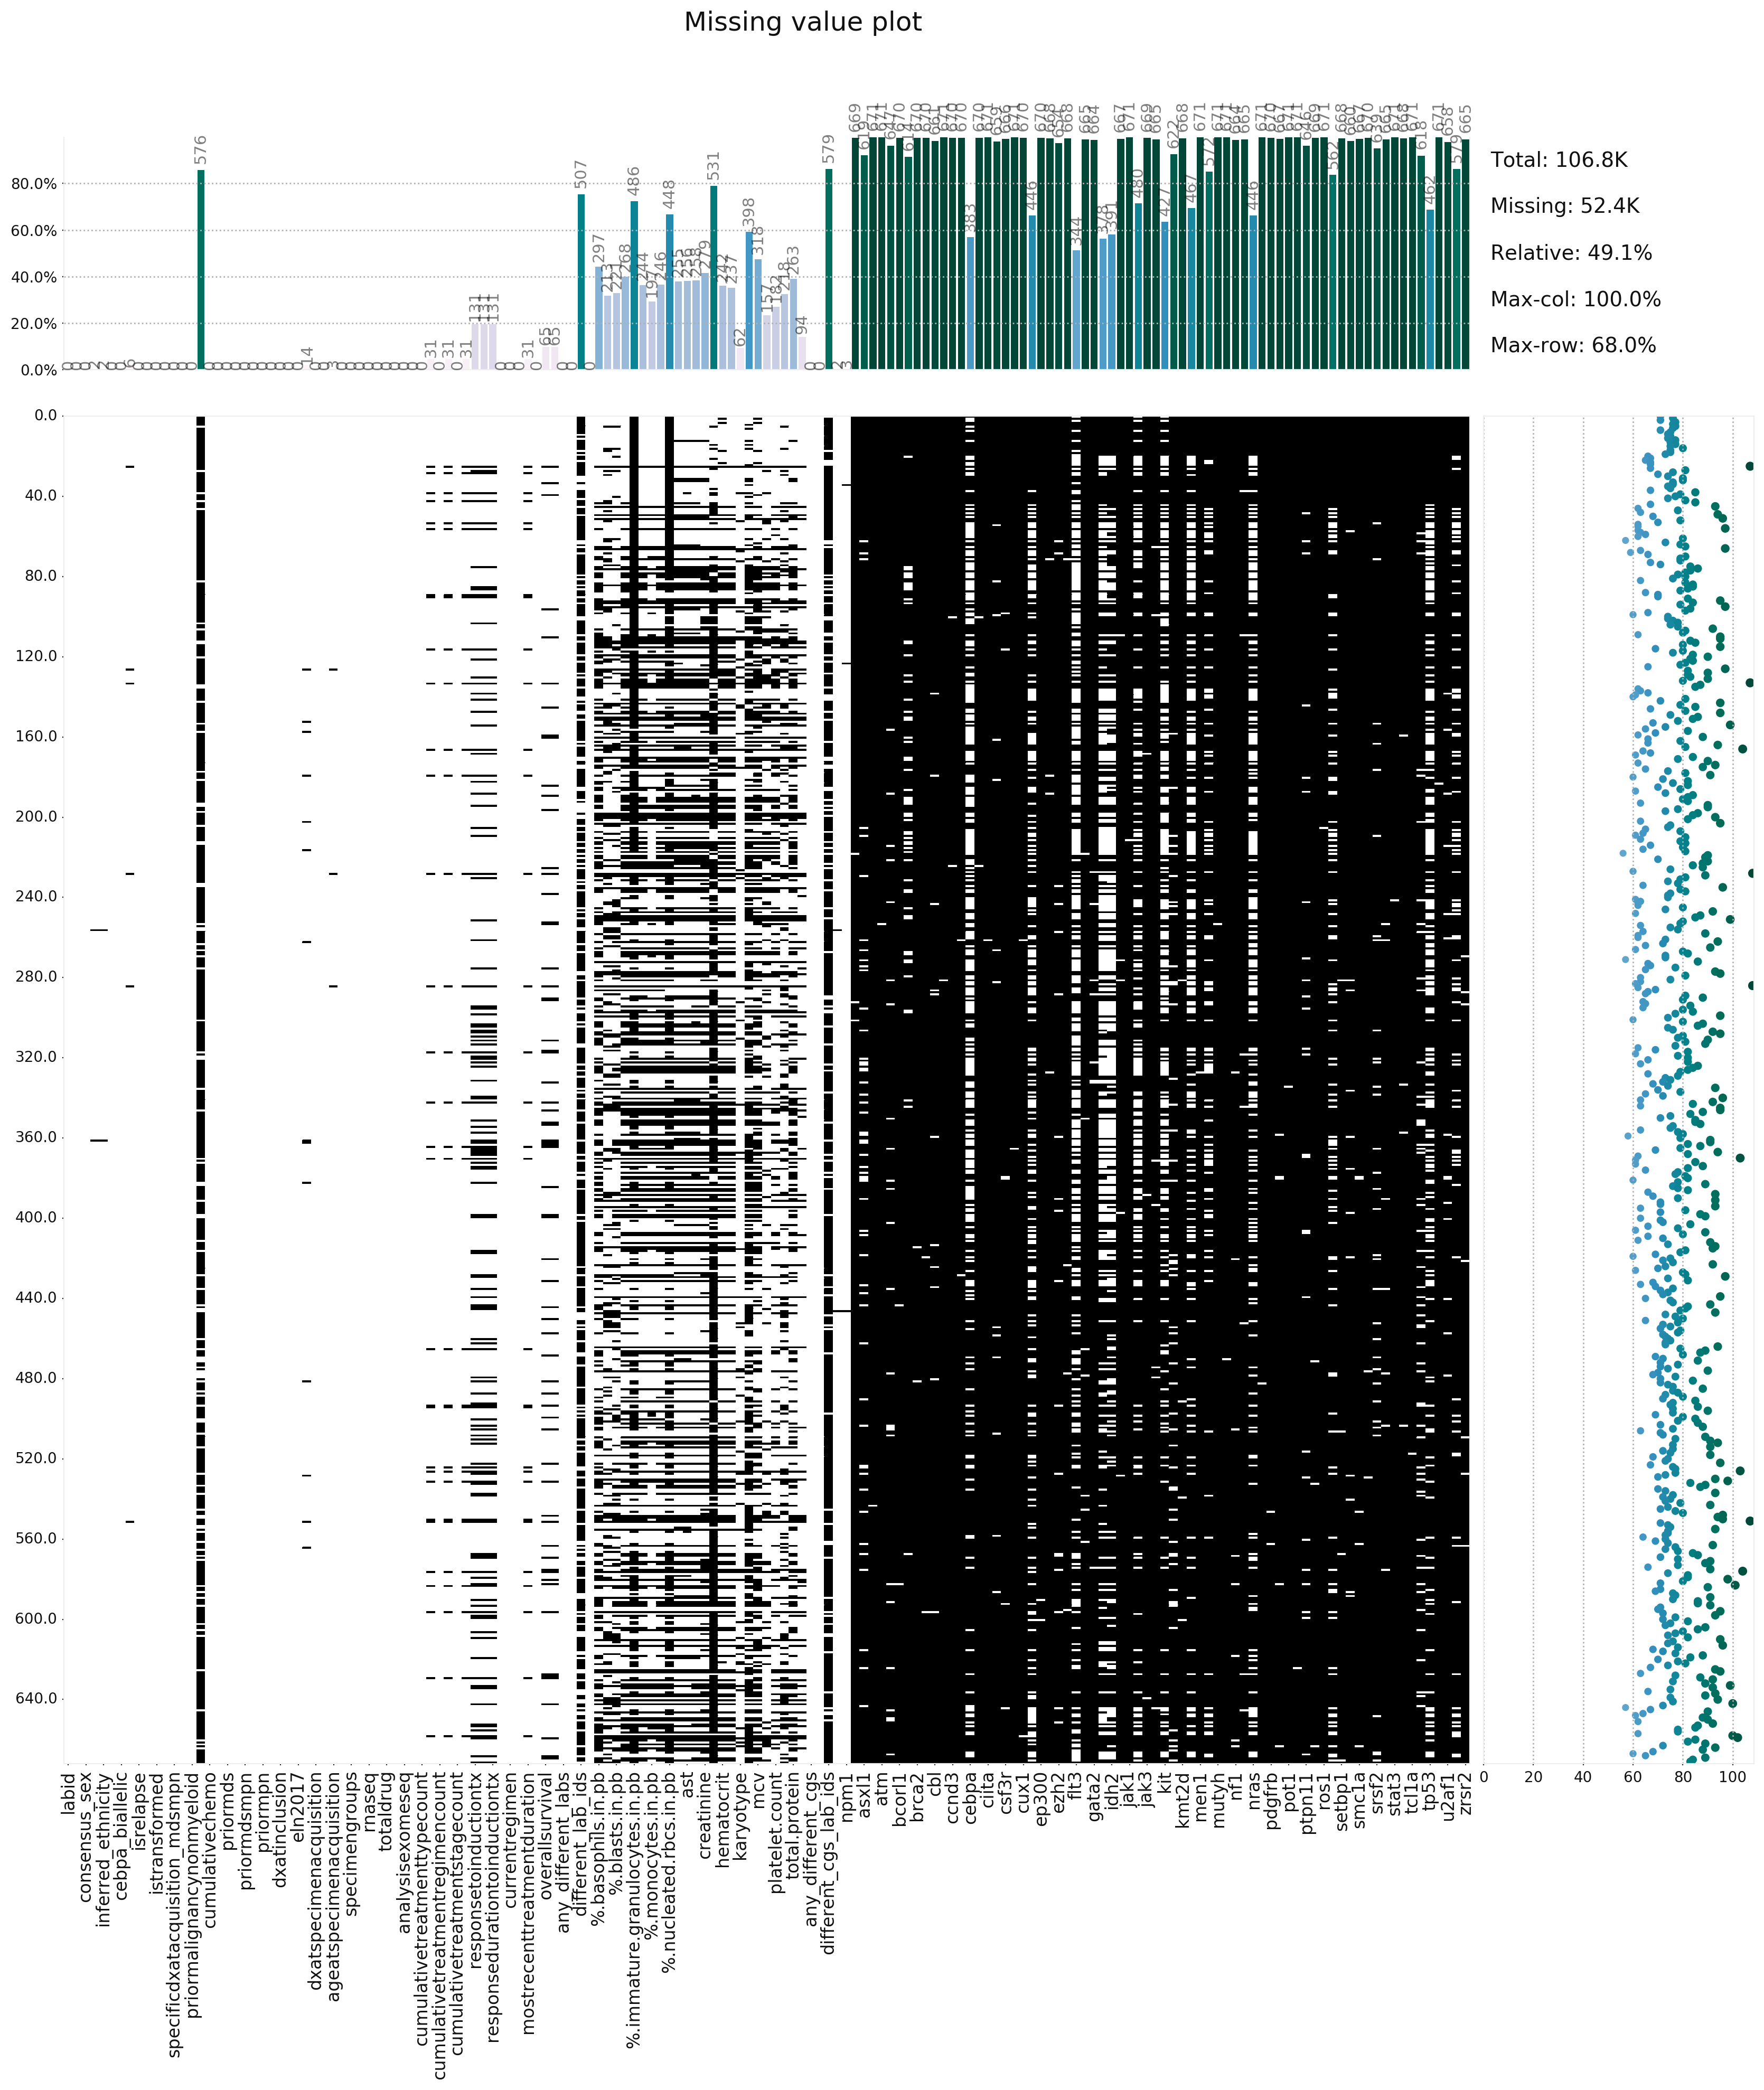

In [50]:
klib.missingval_plot(clsm)

### Select Relevant Features

In [51]:
clsm_cut = pd.DataFrame(clsm[['labid', 'patientid', 'consensus_sex', 'inferred_ethnicity', 'isrelapse',
                             'istransformed', 'priormalignancynonmyeloid', 'priormds', 'priormdsmpn', 'priormpn',
                             'eln2017', 'dxatspecimenacquisition', 'vitalstatus', 'overallsurvival', '%.blasts.in.bm', 
                              '%.blasts.in.pb','flt3-itd', 'npm1']])

clsm_cut

,labid,patientid,consensus_sex,inferred_ethnicity,isrelapse,istransformed,priormalignancynonmyeloid,priormds,priormdsmpn,priormpn,eln2017,dxatspecimenacquisition,vitalstatus,overallsurvival,%.blasts.in.bm,%.blasts.in.pb,flt3-itd,npm1
0,09-00705,163,Male,White,False,False,n,n,n,n,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,425.0,94,97,positive,positive
1,10-00136,174,Male,White,False,False,n,n,n,n,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,419.0,80,19,positive,negative
2,10-00172,175,Female,White,False,False,n,n,n,n,IntermediateOrAdverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,541.0,91,99,positive,negative
3,10-00507,45,Female,White,False,False,n,n,n,n,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,511.0,97,97,positive,positive
4,10-00542,174,Male,White,True,False,n,n,n,n,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,419.0,87,80,positive,negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,17-00072,4366,Male,White,False,True,n,n,n,y,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,362.0,NaN,53.2,negative,negative
668,17-00077,4317,Female,White,False,False,n,n,n,n,Favorable,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Unknown,NaN,90,74,negative,negative
669,17-00093,4379,Female,Black,False,True,n,n,n,y,Intermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Unknown,NaN,NaN,48,positive,negative
670,17-00094,4380,Male,White,False,True,n,n,n,y,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Alive,153.0,20,NaN,negative,negative


In [52]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            607 non-null    float64

In [53]:
clsm_cut.describe()

,patientid,overallsurvival
count,672.000000,607.000000
mean,2088.020833,441.881384
std,973.372734,479.180429
min,17.000000,-1.000000
25%,1450.750000,167.000000
50%,2016.000000,323.000000
75%,2501.500000,555.000000
max,4380.000000,5305.000000


### Attribute Tranformation

#### % Blasts Attributes Numerical Prep

%.blasts.in.bm Attribute:

In [54]:
clsm_cut['%.blasts.in.bm'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12',
       '46.0', '13', '67', '39', '25.9', '45', '37', '78', '8', '3',
       '54.8', '74', '96', '4', '86.1', '42', '56', '69', '79', '33', '9',
       '.4', '51.5', '15', '5', '24', '7', '2', '6', '1', '58', '>50',
       '35', '86', '32.0', '93.2', '0', '27', '89.6', '23', '98', '19',
       '91.8', '>95', '57', '71.5', '78.3', '63', '1.5', '53.74', '59.5',
       '44', '42.5', '26', '3.5', '48', '26.3', '47', '88.5'],
      dtype=object)

In [55]:
# > and < will be changed to whole numbers less than or greater than.
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].replace(['>50'], 51)
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].replace(['>95'], 96)

clsm_cut['%.blasts.in.bm'].unique()

array(['94', '80', '91', '97', '87', nan, '40', '75', '83', '95', '85',
       '90', '70', '92', '72', '68', '88', '36', '81', '93', '34', '77.5',
       '46', '65', '50', '76', '71', '60', '73', '55', '0.5', '30', '62',
       '18', '82', '28', '41', '64', '84', '21', '51', '17', '49.4', '32',
       '29', '25', '59.3', '66', '20', '52', '54', '22', '10', '12',
       '46.0', '13', '67', '39', '25.9', '45', '37', '78', '8', '3',
       '54.8', '74', '96', '4', '86.1', '42', '56', '69', '79', '33', '9',
       '.4', '51.5', '15', '5', '24', '7', '2', '6', '1', '58', 51, '35',
       '86', '32.0', '93.2', '0', '27', '89.6', '23', '98', '19', '91.8',
       96, '57', '71.5', '78.3', '63', '1.5', '53.74', '59.5', '44',
       '42.5', '26', '3.5', '48', '26.3', '47', '88.5'], dtype=object)

%.blasts.in.pb Attribute:

In [56]:
clsm_cut['%.blasts.in.pb'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', '>90', '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', '<5', '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1.0', '2', '20', '28',
       '35', '85', '1', '42.4', '16', '49.1', '14', '88', '46', '7',
       '0.5', '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90',
       '17.4', '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11',
       '90.5', '"""rare"""', '90.2', '55', '12.0', 'rare', '39', '31.0',
       '86', '47.4', '27.4', '39.6', '83.0', '12.9', '5.0', '15.4', '9.5',
       '62', '64.6', '27.8', '69.14', '52.2', '91', '67.25', '49', '23.7',
       '48.6', '98', '74.8', '2.6', '43', '29.6', '47.5', '38', '2.5',
       '25.2', '3.56', '70', '99.2', '73', '26.7', '38.5

In [57]:
#%.Blasts.in.PB attribute has 1 "rare" record with no flt3 nor npm1 input. This will be changed to NAN
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['"""rare"""'], np.nan)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['rare'], np.nan)
# > and < will be changed to whole numbers less than or greater than. 
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['<5'], 4)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].replace(['>90'], 91)

clsm_cut['%.blasts.in.pb'].unique()

array(['97', '19', '99', '80', nan, '51', '30', '41', '84', '77', '75',
       '63', '60', '96', '66', '45', '93', '9', '82', '15', '33', '0',
       '13', '94', '89', '83', 91, '78', '72', '59', '32', '6', '29',
       '24', '64', '57', '52', '2.1', 4, '17', '22', '5', '47', '56',
       '25', '23', '42', '65', '71', '8', '3.5', '66.3', '95', '44', '10',
       '28.6', '18', '58', '67', '40', '92', '54', '1.0', '2', '20', '28',
       '35', '85', '1', '42.4', '16', '49.1', '14', '88', '46', '7',
       '0.5', '79', '26', '87', '20.4', '68', '48', '5.3', '61', '90',
       '17.4', '57.4', '43.8', '50', '37', '4', '3', '12', '81', '11',
       '90.5', '90.2', '55', '12.0', '39', '31.0', '86', '47.4', '27.4',
       '39.6', '83.0', '12.9', '5.0', '15.4', '9.5', '62', '64.6', '27.8',
       '69.14', '52.2', '91', '67.25', '49', '23.7', '48.6', '98', '74.8',
       '2.6', '43', '29.6', '47.5', '38', '2.5', '25.2', '3.56', '70',
       '99.2', '73', '26.7', '38.5', '7.7', '74', '93.3', '12.

#### From Categorical to Numerical
Transform %.blasts.in.bm and %.blasts.in.pb from object to float:

In [58]:
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].astype(float)
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].astype(float)


clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         670 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            607 non-null    float64

### clsm_cut Identify Missing Values

GridSpec(6, 6)

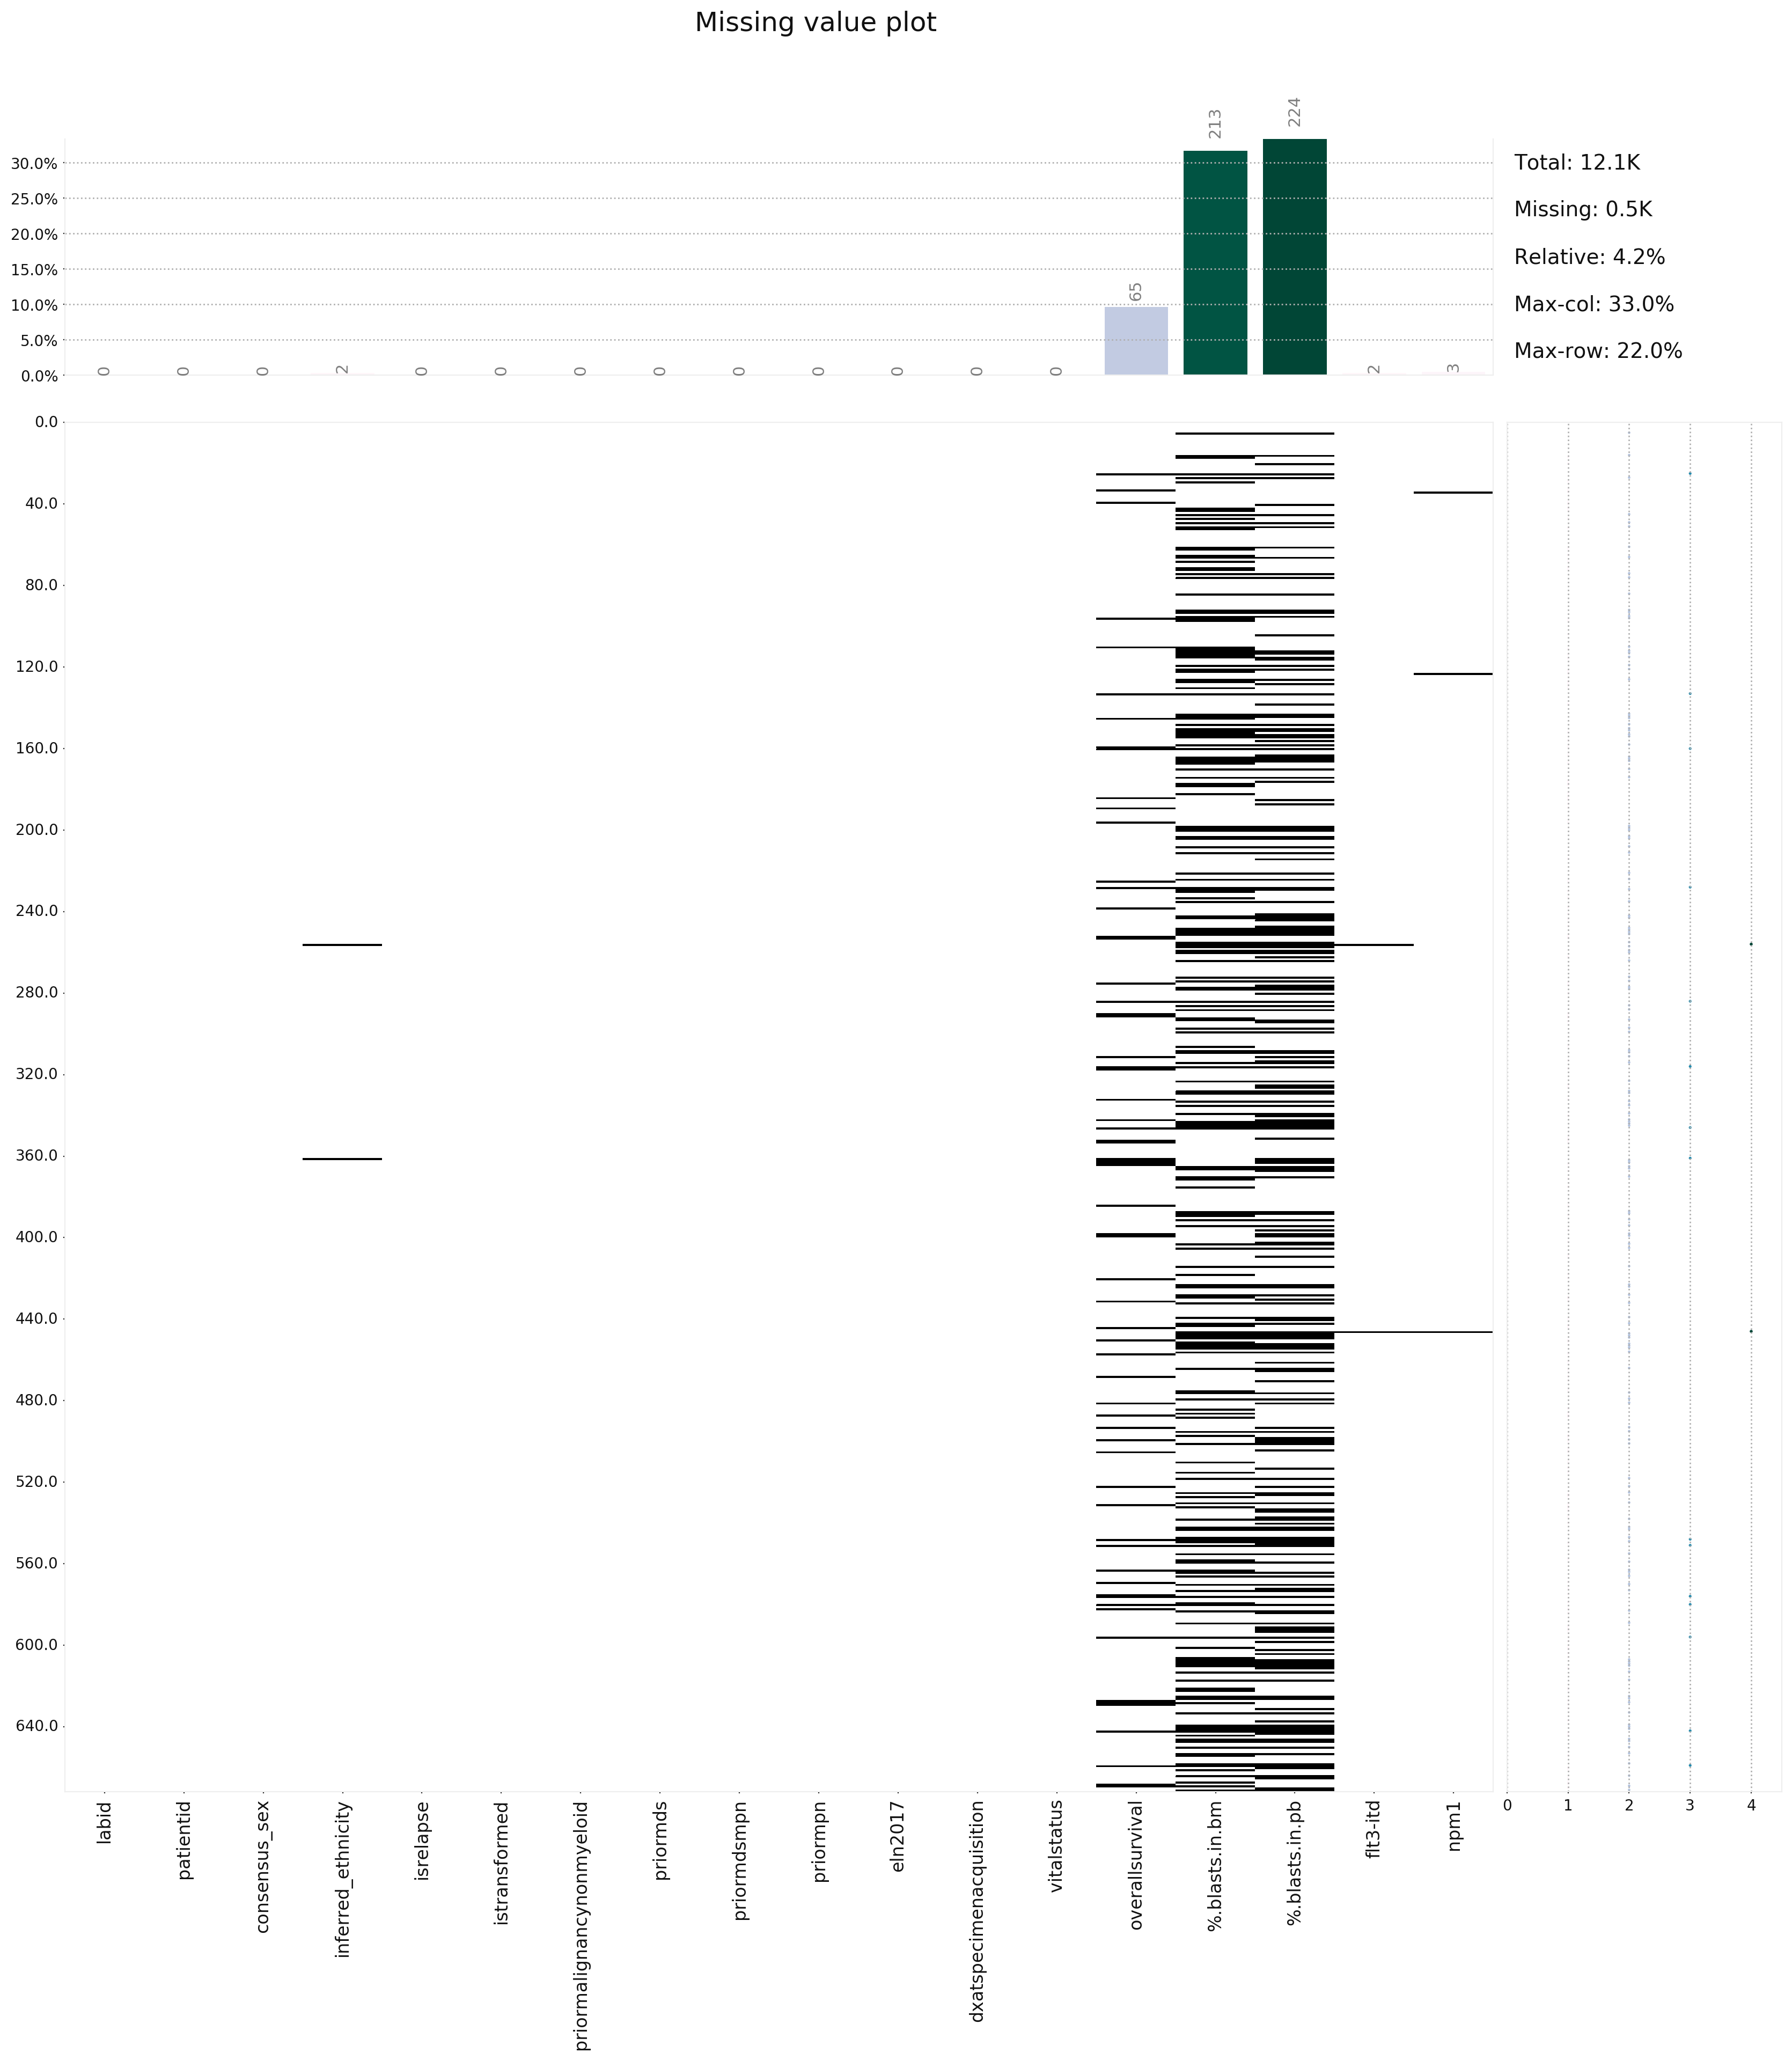

In [59]:
klib.missingval_plot(clsm_cut)

### Replace Missing Values

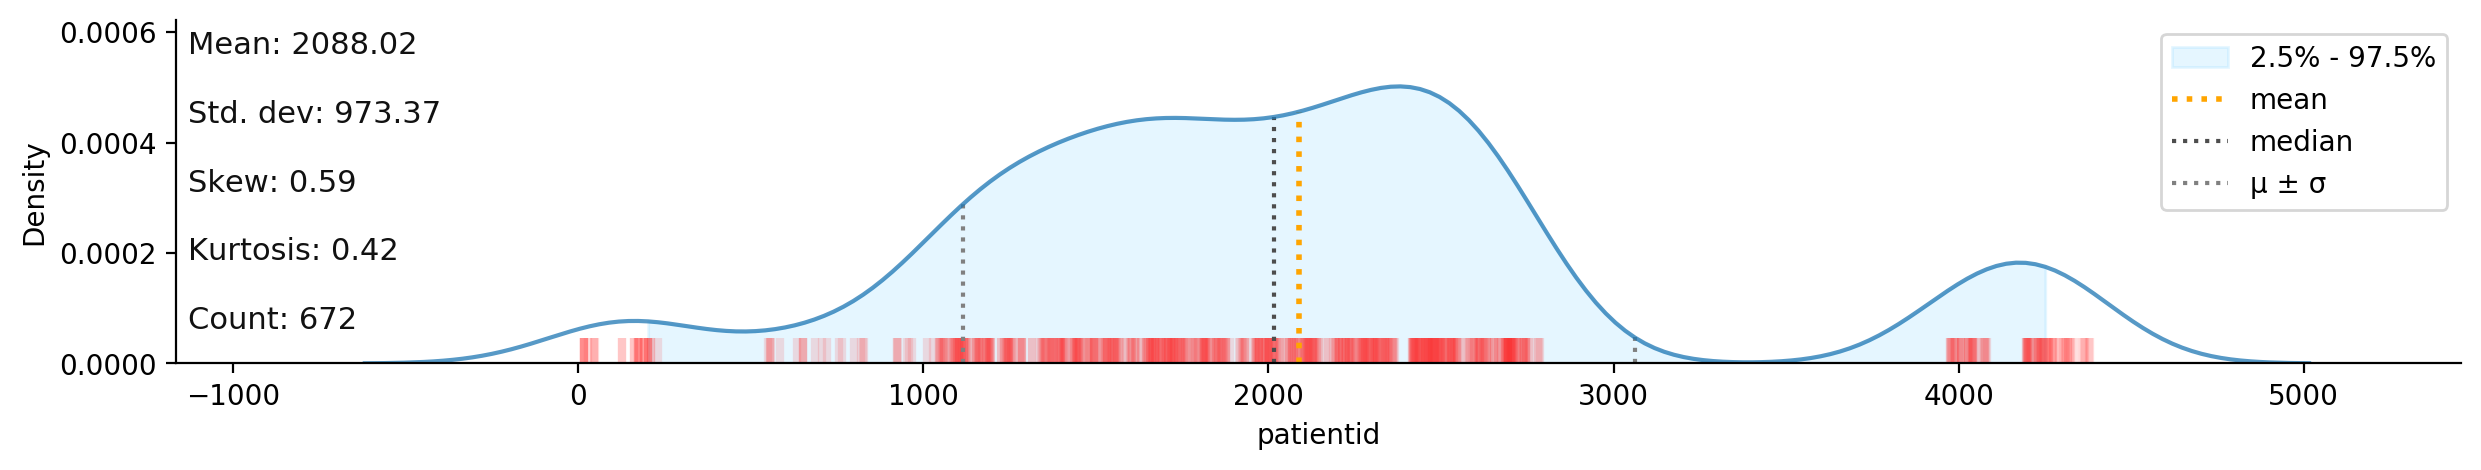

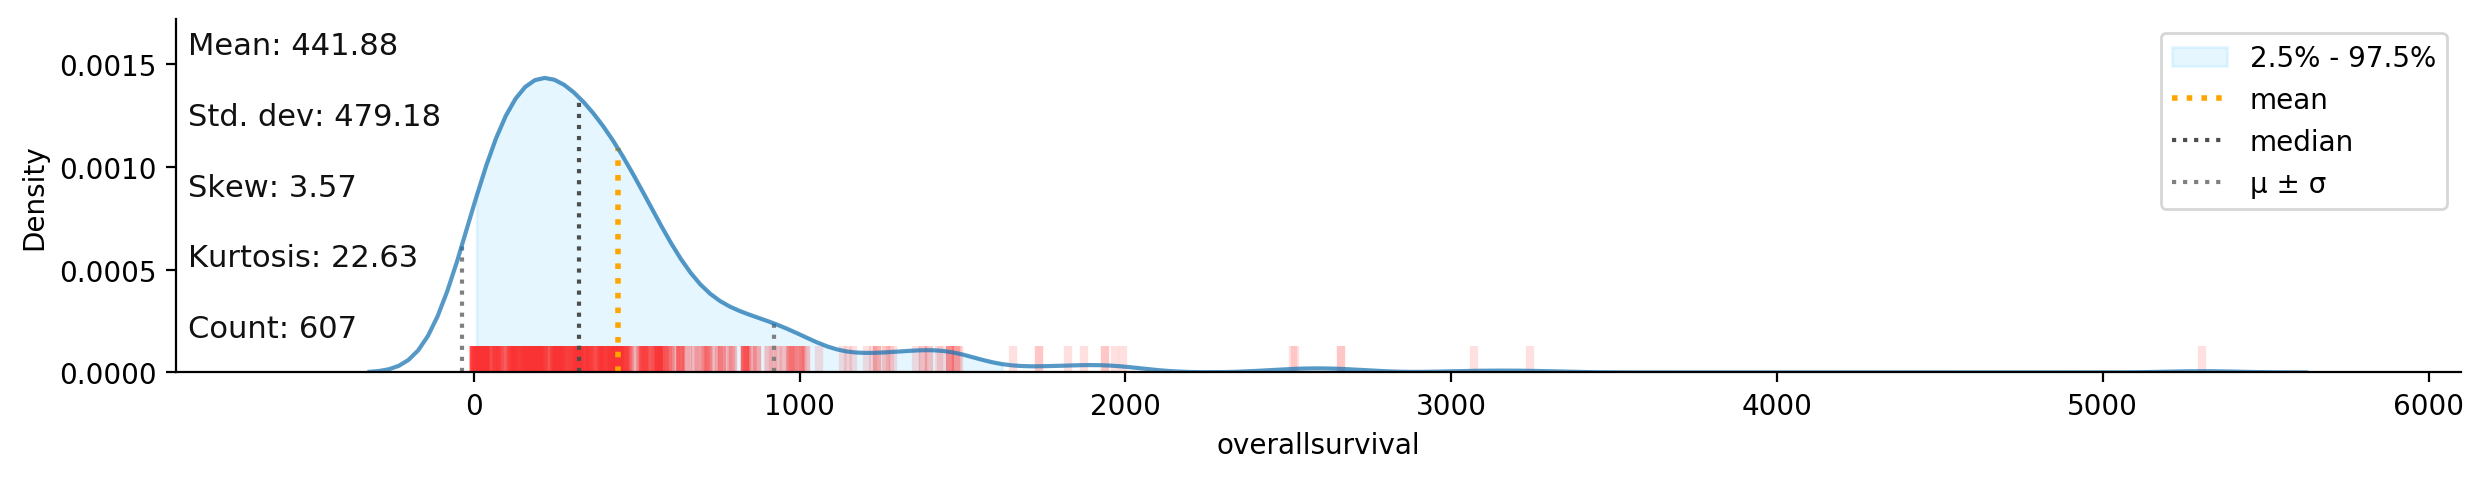

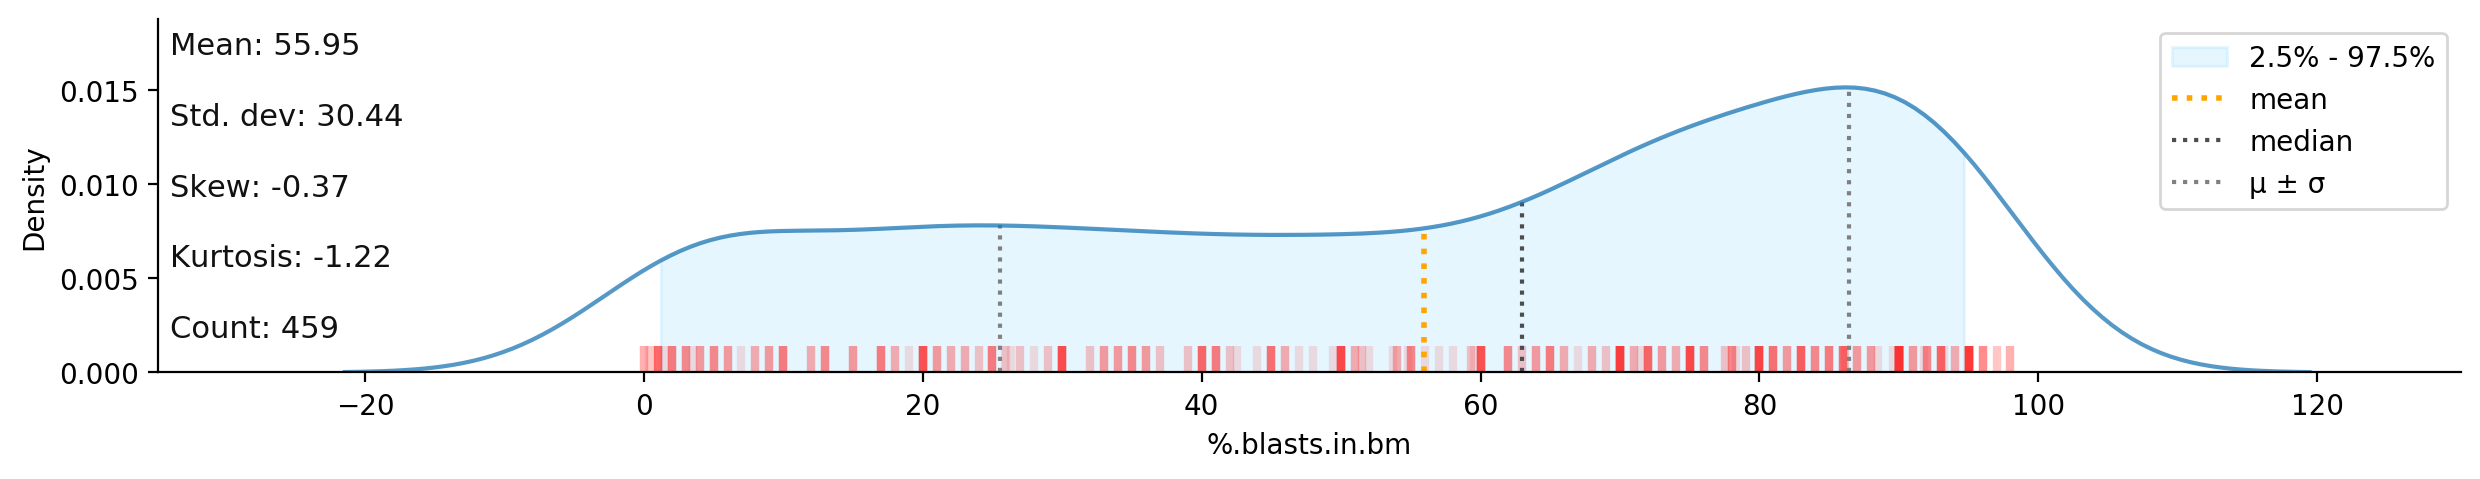

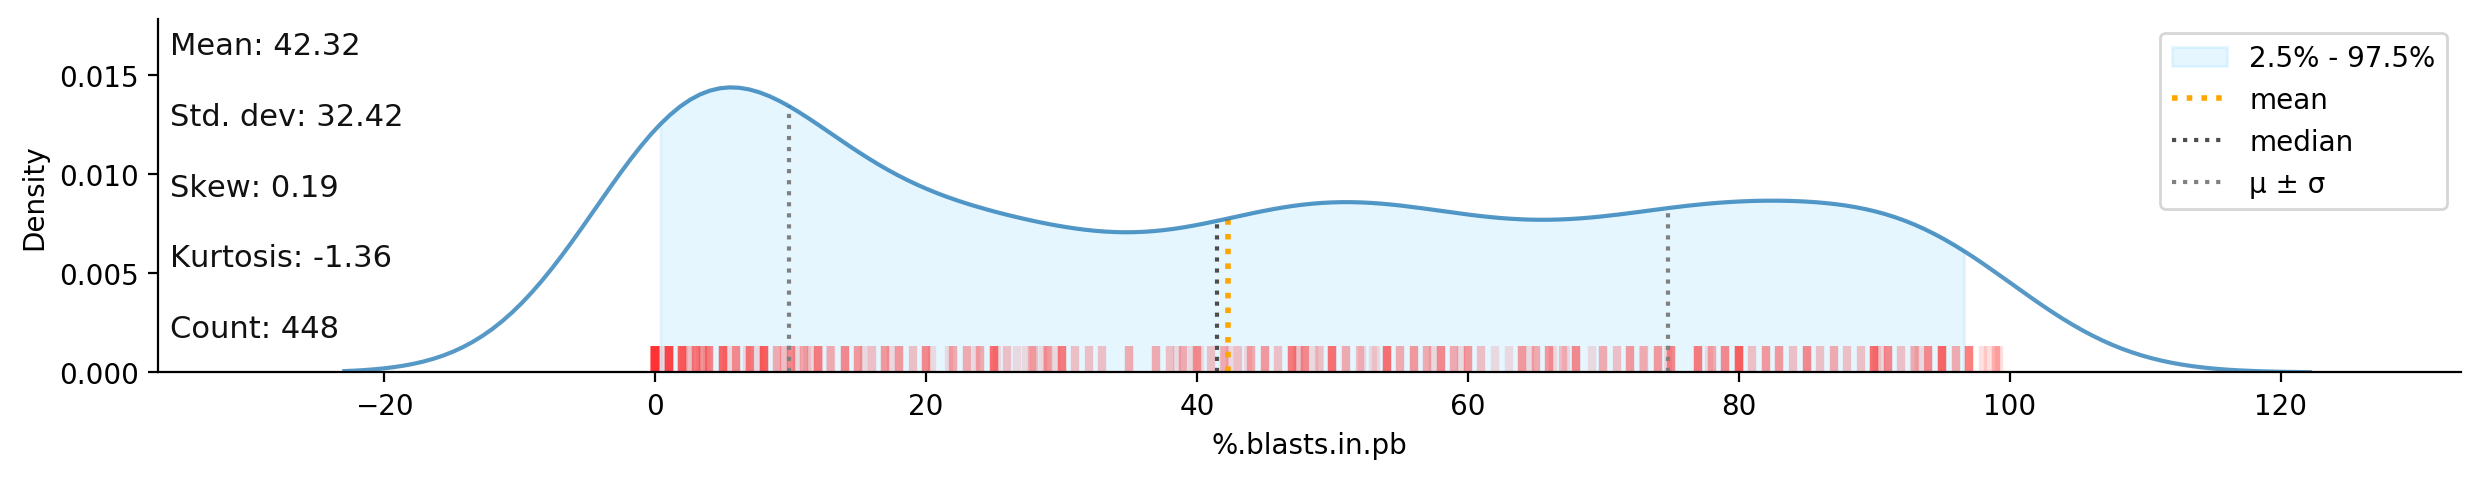

In [60]:
klib.dist_plot(clsm_cut)

In [61]:
clsm_cut.describe()

,patientid,overallsurvival,%.blasts.in.bm,%.blasts.in.pb
count,672.000000,607.000000,459.000000,448.000000
mean,2088.020833,441.881384,55.949325,42.316629
std,973.372734,479.180429,30.440925,32.418249
min,17.000000,-1.000000,0.000000,0.000000
25%,1450.750000,167.000000,30.000000,10.000000
50%,2016.000000,323.000000,63.000000,41.500000
75%,2501.500000,555.000000,83.000000,72.000000
max,4380.000000,5305.000000,98.000000,99.200000


In [62]:
#From distibution, skewness suggest median is the best representation. 
clsm_cut['overallsurvival'] = clsm_cut['overallsurvival'].fillna(clsm_cut['overallsurvival'].median())
clsm_cut['%.blasts.in.bm'] = clsm_cut['%.blasts.in.bm'].fillna(clsm_cut['%.blasts.in.bm'].median())
clsm_cut['%.blasts.in.pb'] = clsm_cut['%.blasts.in.pb'].fillna(clsm_cut['%.blasts.in.pb'].median())

In [63]:
#Replace categorical NaN with unknown 
clsm_cut = clsm_cut.replace(np.nan, 'unknown', regex=True)

In [64]:
#Determine mode of inferred_ethnicity:
clsm_cut['inferred_ethnicity'].mode()

0    White
dtype: object

In [65]:
#In inferred_ethnicity, replace mode of unknown to white:
clsm_cut['inferred_ethnicity'] = clsm_cut['inferred_ethnicity'].replace(['unknown'], 'white')

clsm_cut['inferred_ethnicity'].unique()

array(['White', 'HispNative', 'AdmixedBlack', 'Asian', 'Black',
       'AdmixedAsian', 'white', 'AdmixedWhite', 'AdmixedHispNative'],
      dtype=object)

In [66]:
#Determine mode of flt3-itd:
clsm_cut['flt3-itd'].mode()

0    negative
dtype: object

In [67]:
#In flt3-itd, replace mode of unknown to negative:
clsm_cut['flt3-itd'] = clsm_cut['flt3-itd'].replace(['unknown'], 'negative')

clsm_cut['flt3-itd'].unique()

array(['positive', 'negative'], dtype=object)

In [68]:
#Determine mode of npm1:
clsm_cut['npm1'].mode()

0    negative
dtype: object

In [69]:
#In npm1, replace mode of unknown to negative:
clsm_cut['npm1'] = clsm_cut['npm1'].replace(['unknown'], 'negative')

clsm_cut['npm1'].unique()

array(['positive', 'negative'], dtype=object)

In [70]:
klib.missingval_plot(clsm_cut)

No missing values found in the dataset.


In [71]:
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Check for Duplicates

In [72]:
clsm_cut = clsm_cut.drop_duplicates(ignore_index=True)
clsm_cut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   labid                      672 non-null    object 
 1   patientid                  672 non-null    int64  
 2   consensus_sex              672 non-null    object 
 3   inferred_ethnicity         672 non-null    object 
 4   isrelapse                  672 non-null    bool   
 5   istransformed              672 non-null    bool   
 6   priormalignancynonmyeloid  672 non-null    object 
 7   priormds                   672 non-null    object 
 8   priormdsmpn                672 non-null    object 
 9   priormpn                   672 non-null    object 
 10  eln2017                    672 non-null    object 
 11  dxatspecimenacquisition    672 non-null    object 
 12  vitalstatus                672 non-null    object 
 13  overallsurvival            672 non-null    float64

### Create Target Variable

In [73]:
clsm_cut['dxatspecimenacquisition'].value_counts()

ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS    646
MYELODYSPLASTIC SYNDROMES                                         15
MYELODYSPLASTIC/MYELOPROLIFERATIVE NEOPLASMS                       4
ACUTE LEUKAEMIAS OF AMBIGUOUS LINEAGE                              3
MYELOPROLIFERATIVE NEOPLASMS                                       3
MATURE B-CELL NEOPLASMS                                            1
Name: dxatspecimenacquisition, dtype: int64

In [74]:
#create column for AML detected
clsm_cut['AML_detected'] = ['yes' if x == 'ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PRECURSOR NEOPLASMS' 
                            else 'no' for x in clsm_cut['dxatspecimenacquisition']]

In [75]:
clsm_cut.head()

,labid,patientid,consensus_sex,inferred_ethnicity,isrelapse,istransformed,priormalignancynonmyeloid,priormds,priormdsmpn,priormpn,eln2017,dxatspecimenacquisition,vitalstatus,overallsurvival,%.blasts.in.bm,%.blasts.in.pb,flt3-itd,npm1,AML_detected
0,09-00705,163,Male,White,False,False,n,n,n,n,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,425.0,94.0,97.0,positive,positive,yes
1,10-00136,174,Male,White,False,False,n,n,n,n,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,419.0,80.0,19.0,positive,negative,yes
2,10-00172,175,Female,White,False,False,n,n,n,n,IntermediateOrAdverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,541.0,91.0,99.0,positive,negative,yes
3,10-00507,45,Female,White,False,False,n,n,n,n,FavorableOrIntermediate,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,511.0,97.0,97.0,positive,positive,yes
4,10-00542,174,Male,White,True,False,n,n,n,n,Adverse,ACUTE MYELOID LEUKAEMIA (AML) AND RELATED PREC...,Dead,419.0,87.0,80.0,positive,negative,yes


# Data Exploration

Text(0.5, 1.0, 'AML_detected Frequency')

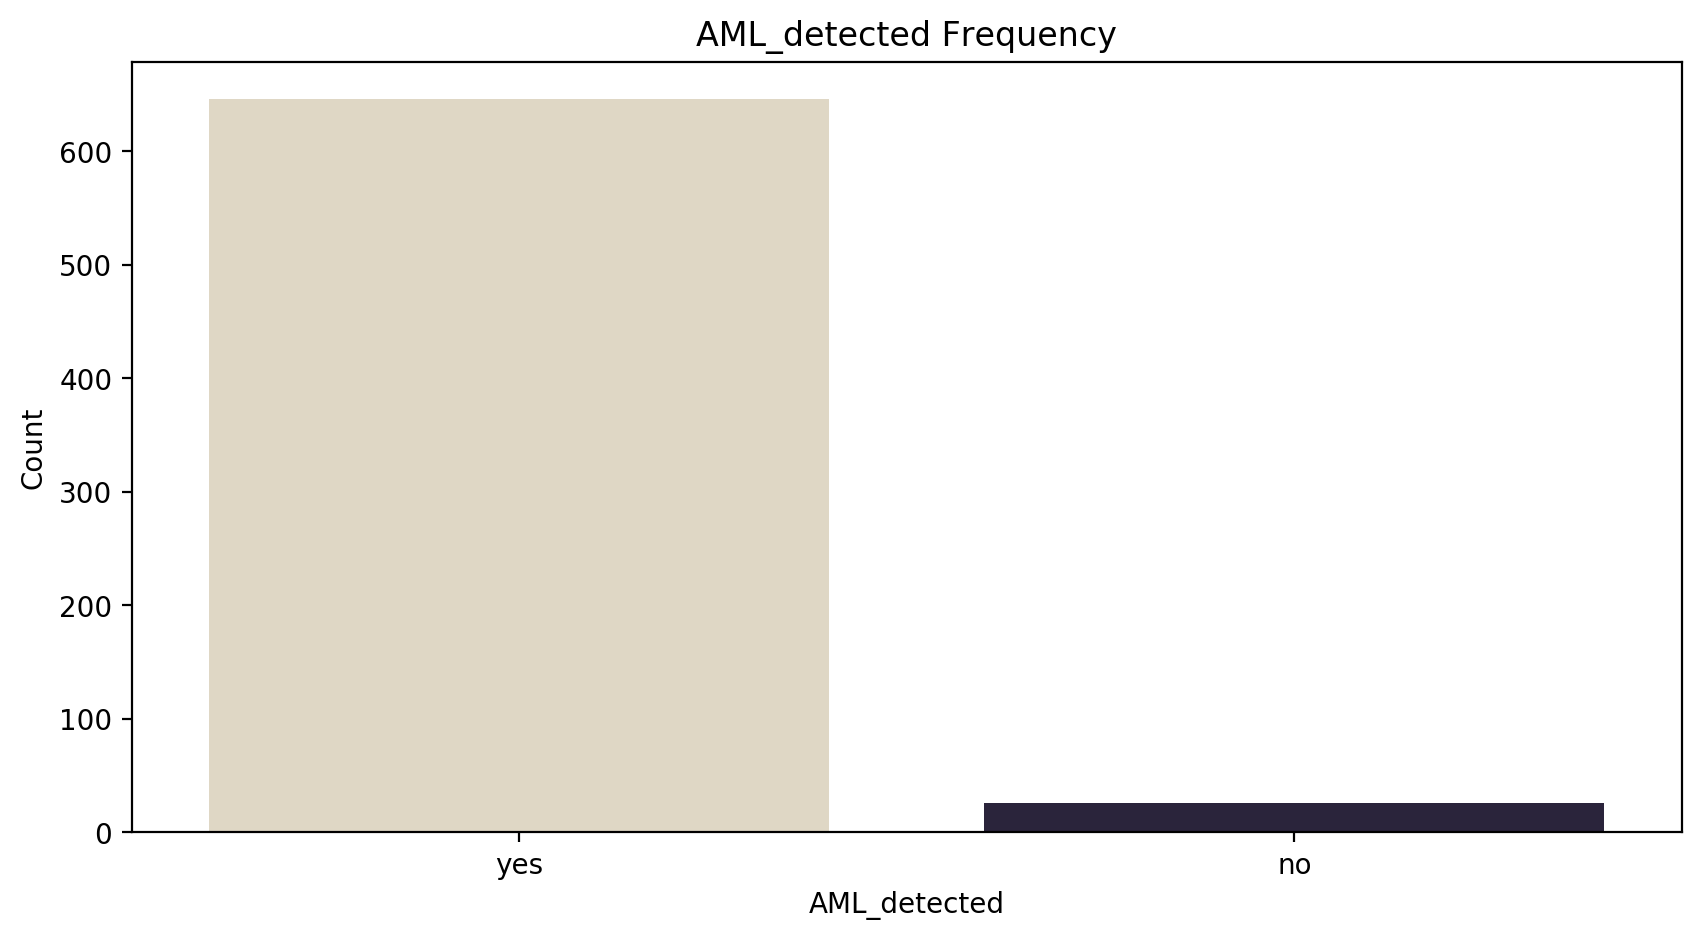

In [77]:
sns.countplot(x=clsm_cut["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 5)
plt.xlabel('AML_detected')
plt.ylabel('Count')
plt.title("AML_detected Frequency")

Text(0.5, 1.0, '%Blast in Bone Marrow Against NPM1 Mutation')

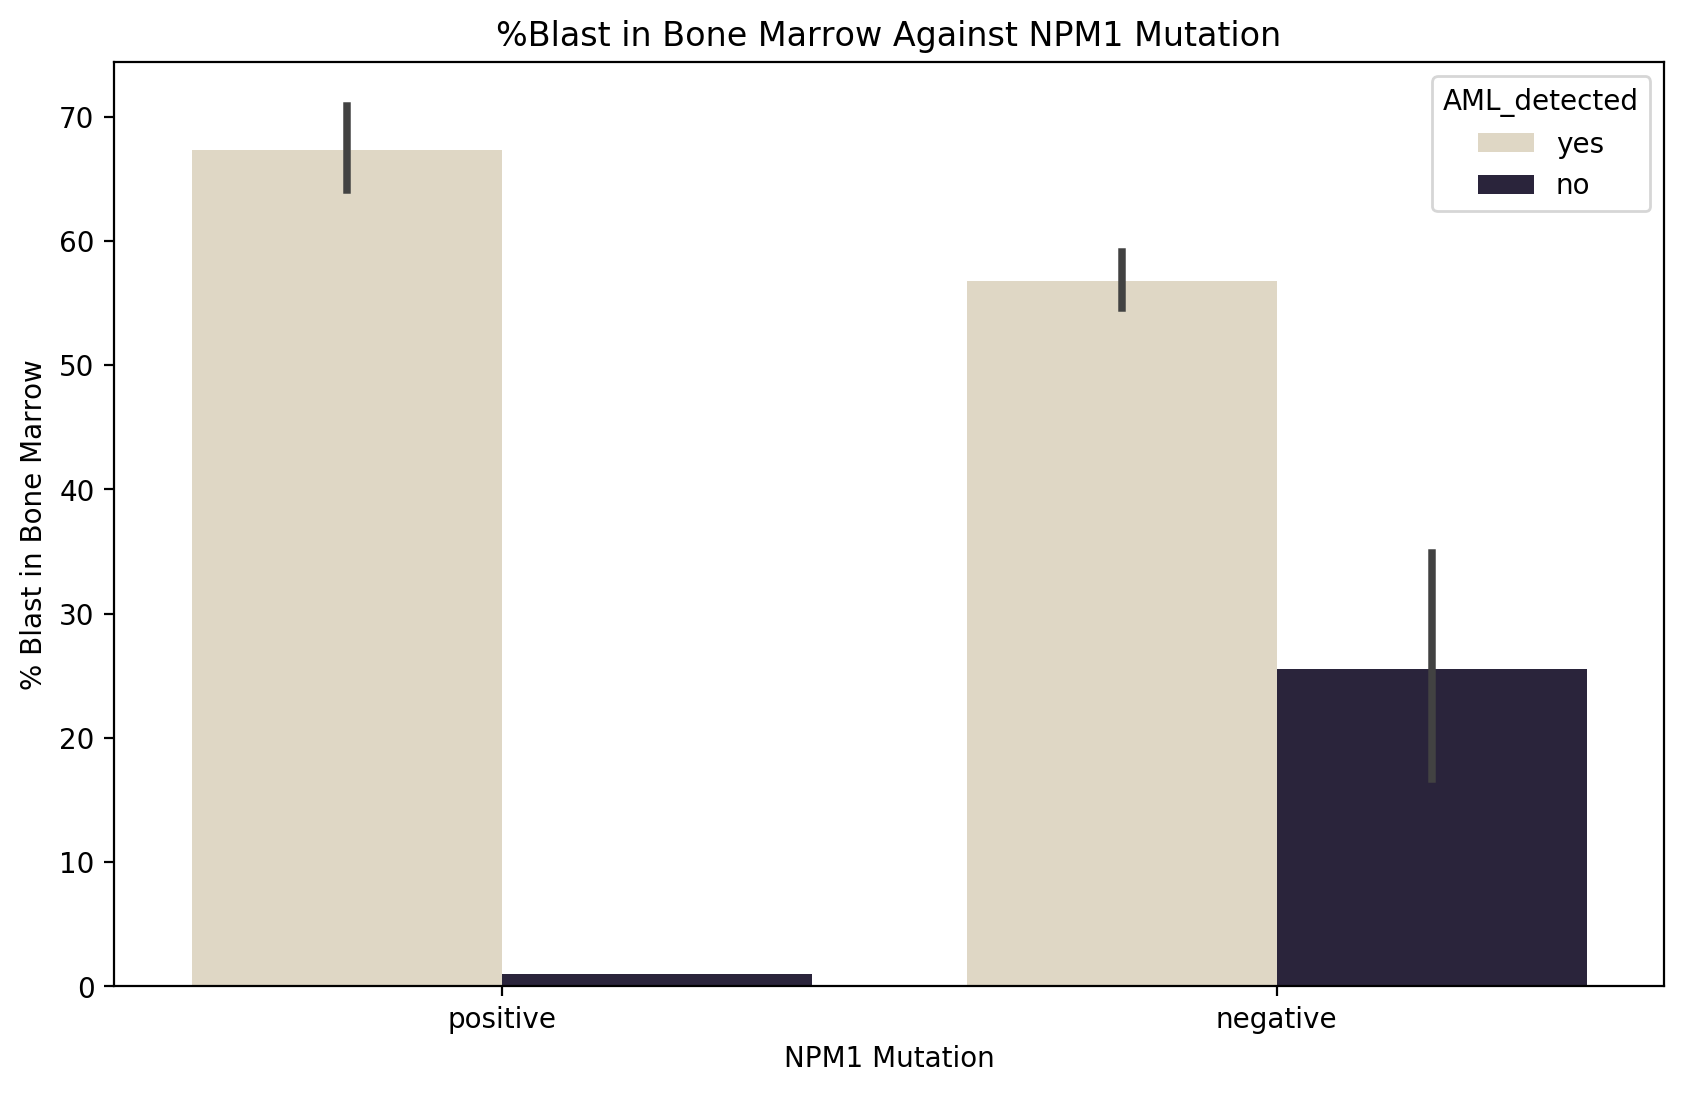

In [78]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.bm', 
            hue = 'AML_detected', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 6)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'AML_detected')
plt.title("%Blast in Bone Marrow Against NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Peripheral Blood Against NPM1 Mutation')

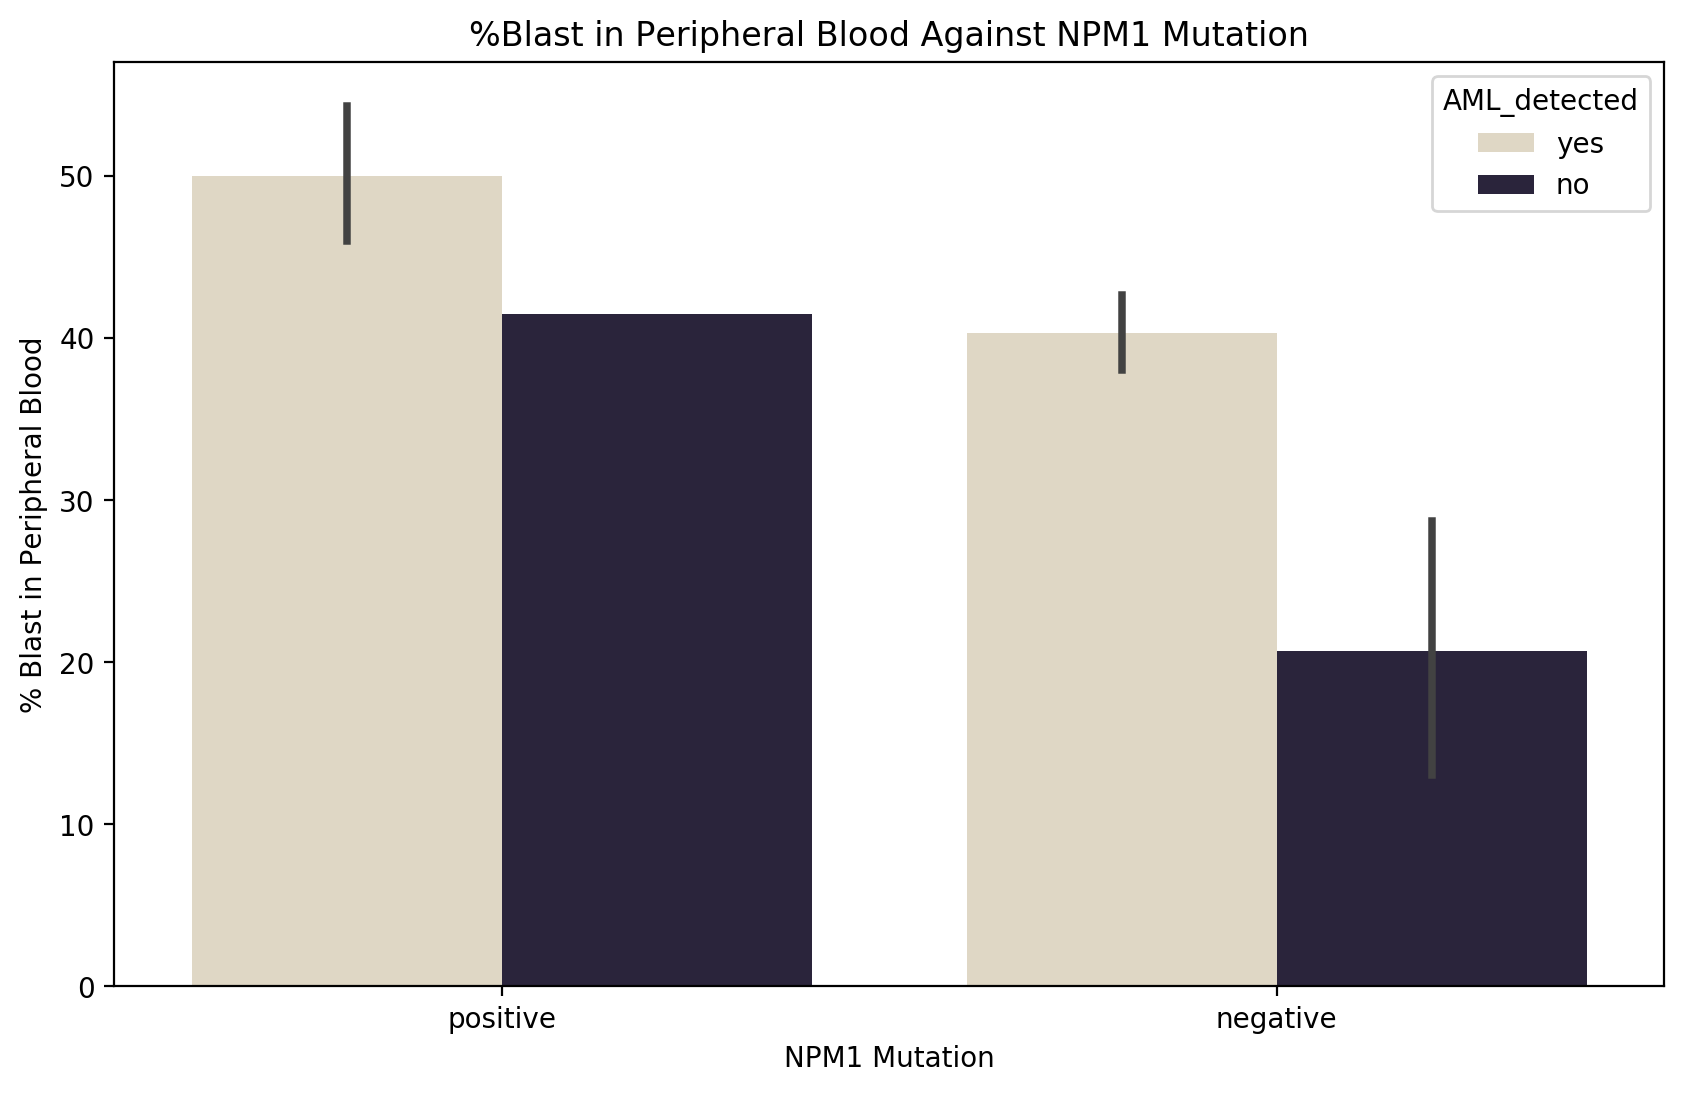

In [79]:
sns.barplot(data= clsm_cut,x = 'npm1', y = '%.blasts.in.pb', 
            hue = 'AML_detected', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 6)
plt.xlabel('NPM1 Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'AML_detected')
plt.title("%Blast in Peripheral Blood Against NPM1 Mutation")

Text(0.5, 1.0, '%Blast in Bone Marrow Against flt3-itd Mutation')

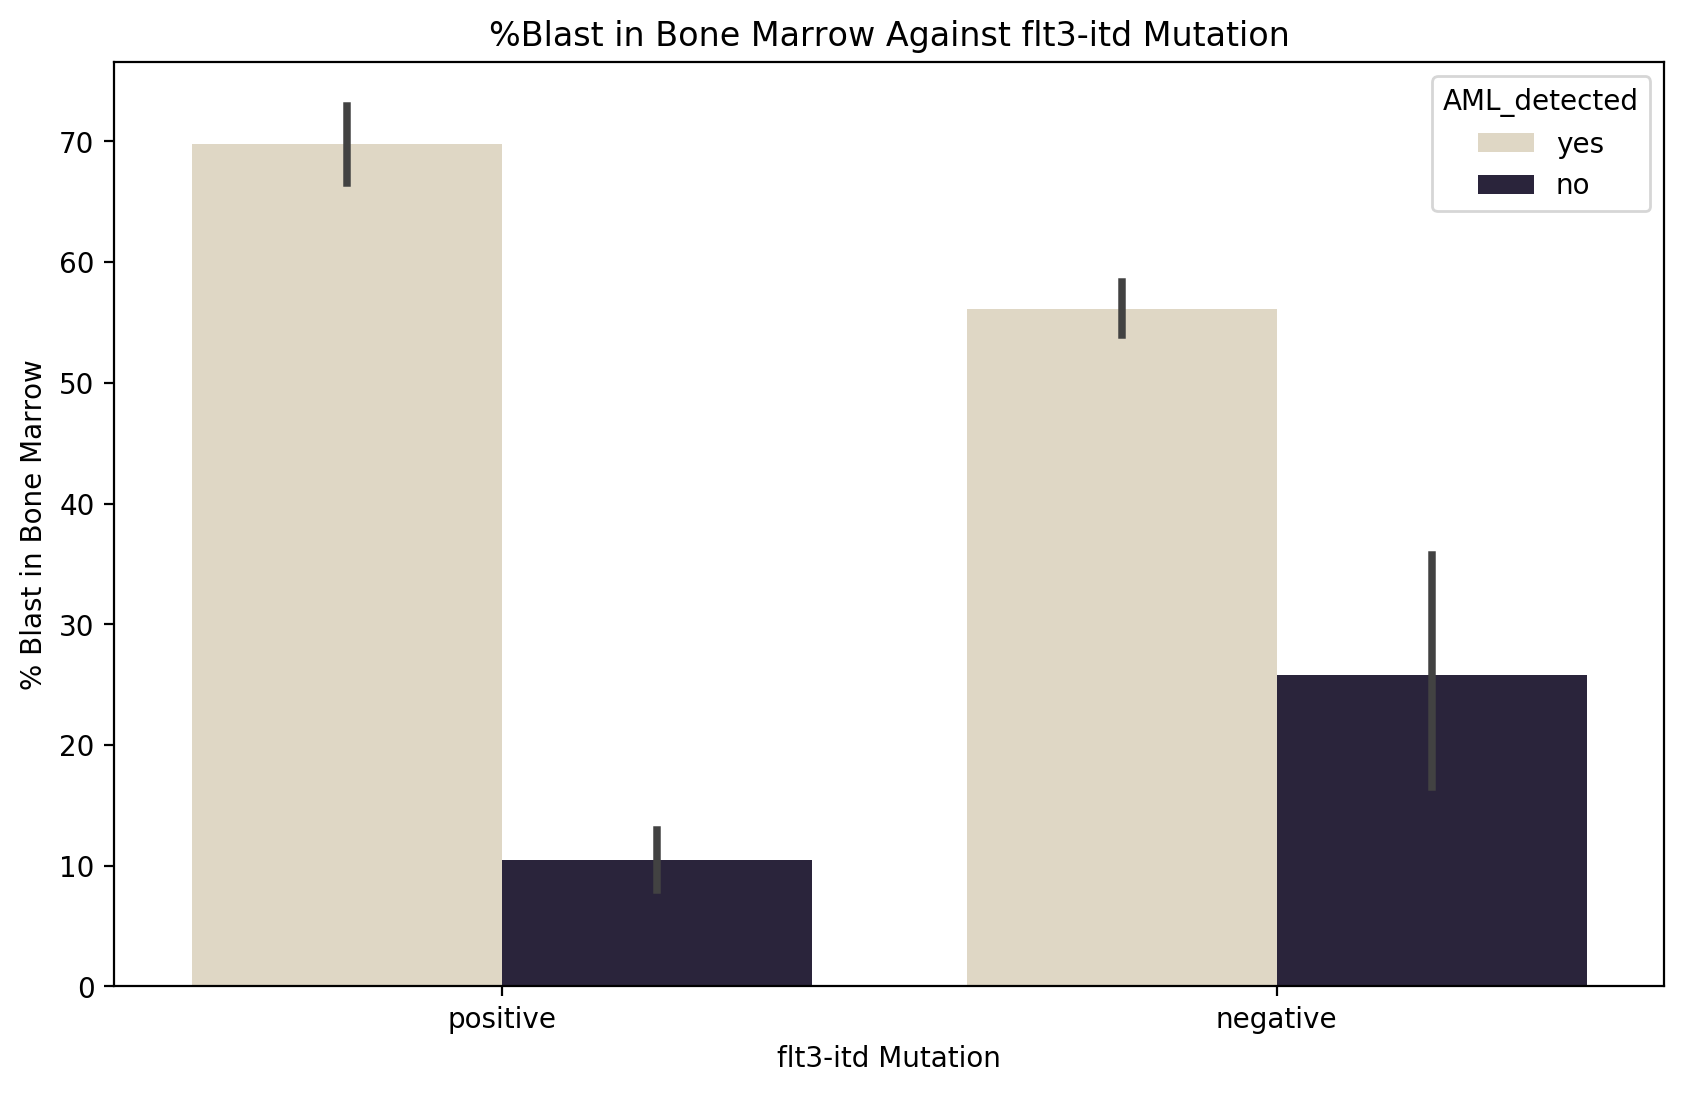

In [80]:
sns.barplot(data= clsm_cut,x = 'flt3-itd', y = '%.blasts.in.bm', 
            hue = 'AML_detected', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 6)
plt.xlabel('flt3-itd Mutation')
plt.ylabel('% Blast in Bone Marrow')
plt.legend(loc='upper right', title = 'AML_detected')
plt.title("%Blast in Bone Marrow Against flt3-itd Mutation")

Text(0.5, 1.0, '%Blast in Peripheral Blood Against flt3-itd Mutation')

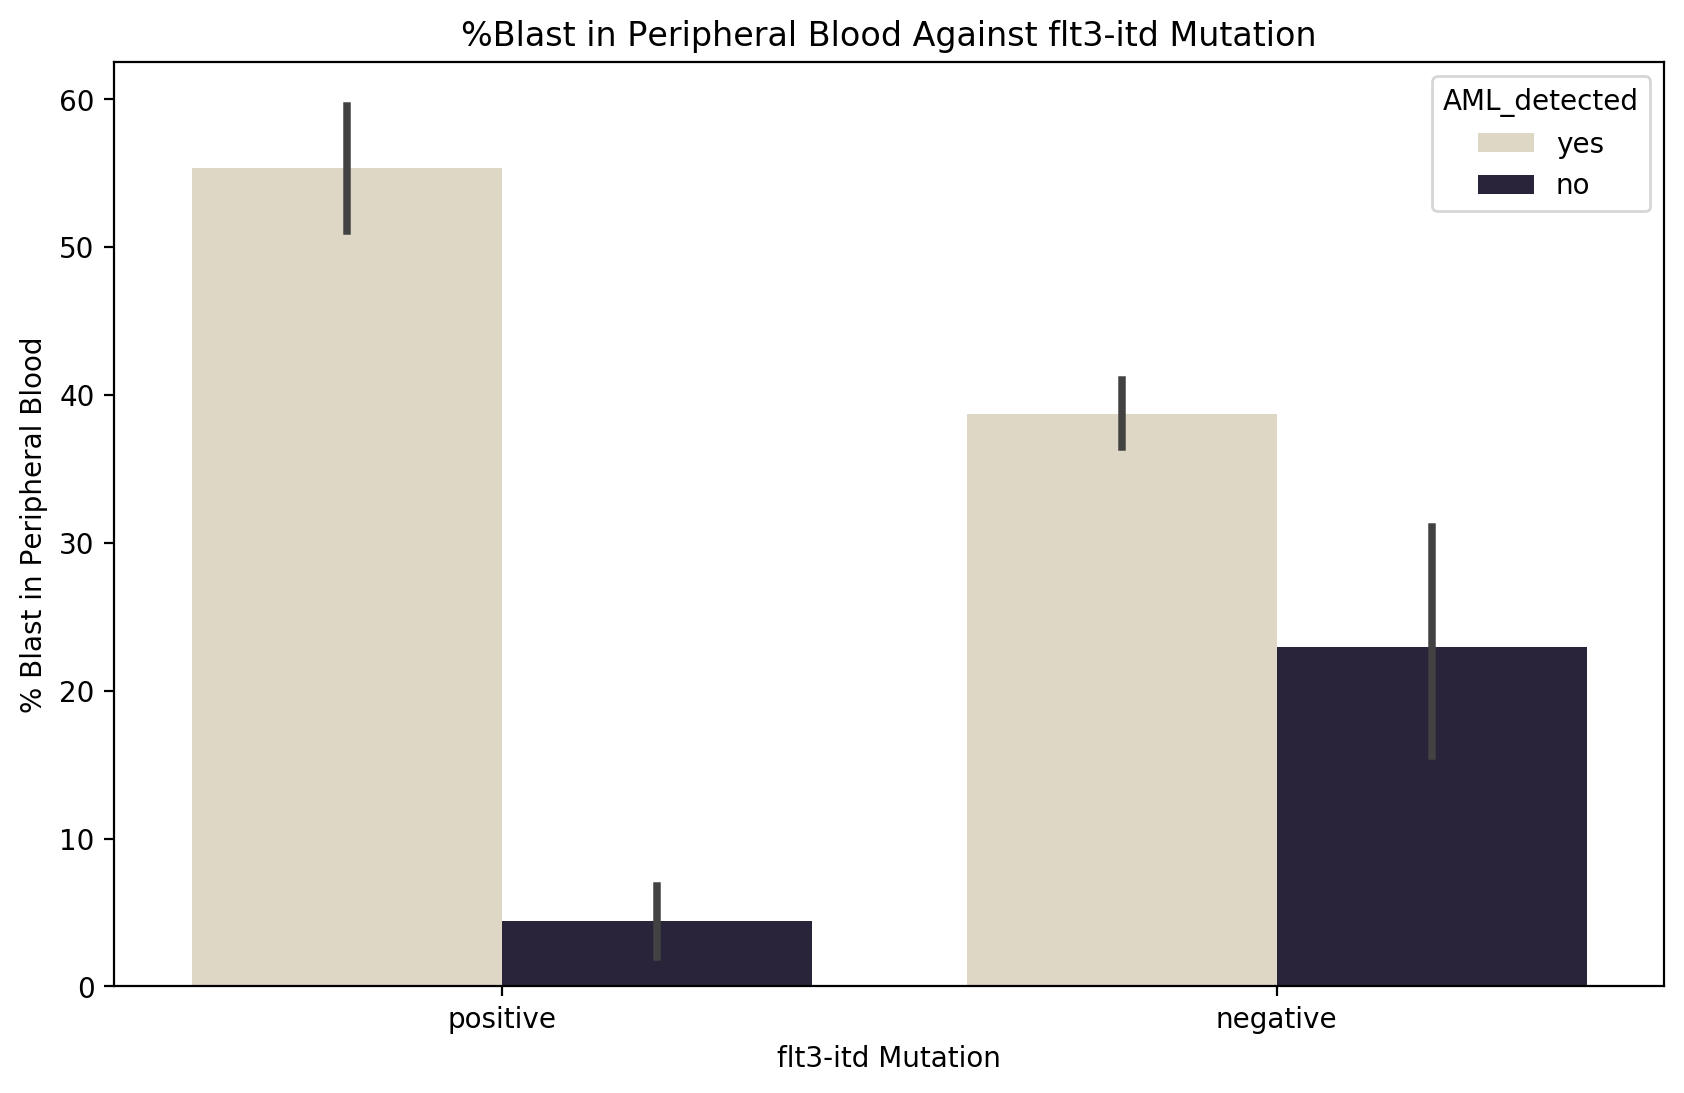

In [81]:
sns.barplot(data= clsm_cut,x = 'flt3-itd', y = '%.blasts.in.pb', 
            hue = 'AML_detected', palette = "ch:s=-.2,r=.6")
plt.gcf().set_size_inches(10, 6)
plt.xlabel('flt3-itd Mutation')
plt.ylabel('% Blast in Peripheral Blood')
plt.legend(loc='upper right', title = 'AML_detected')
plt.title("%Blast in Peripheral Blood Against flt3-itd Mutation")

Text(0.5, 1.0, 'Overall Survival for Prior MDS Diagnosis')

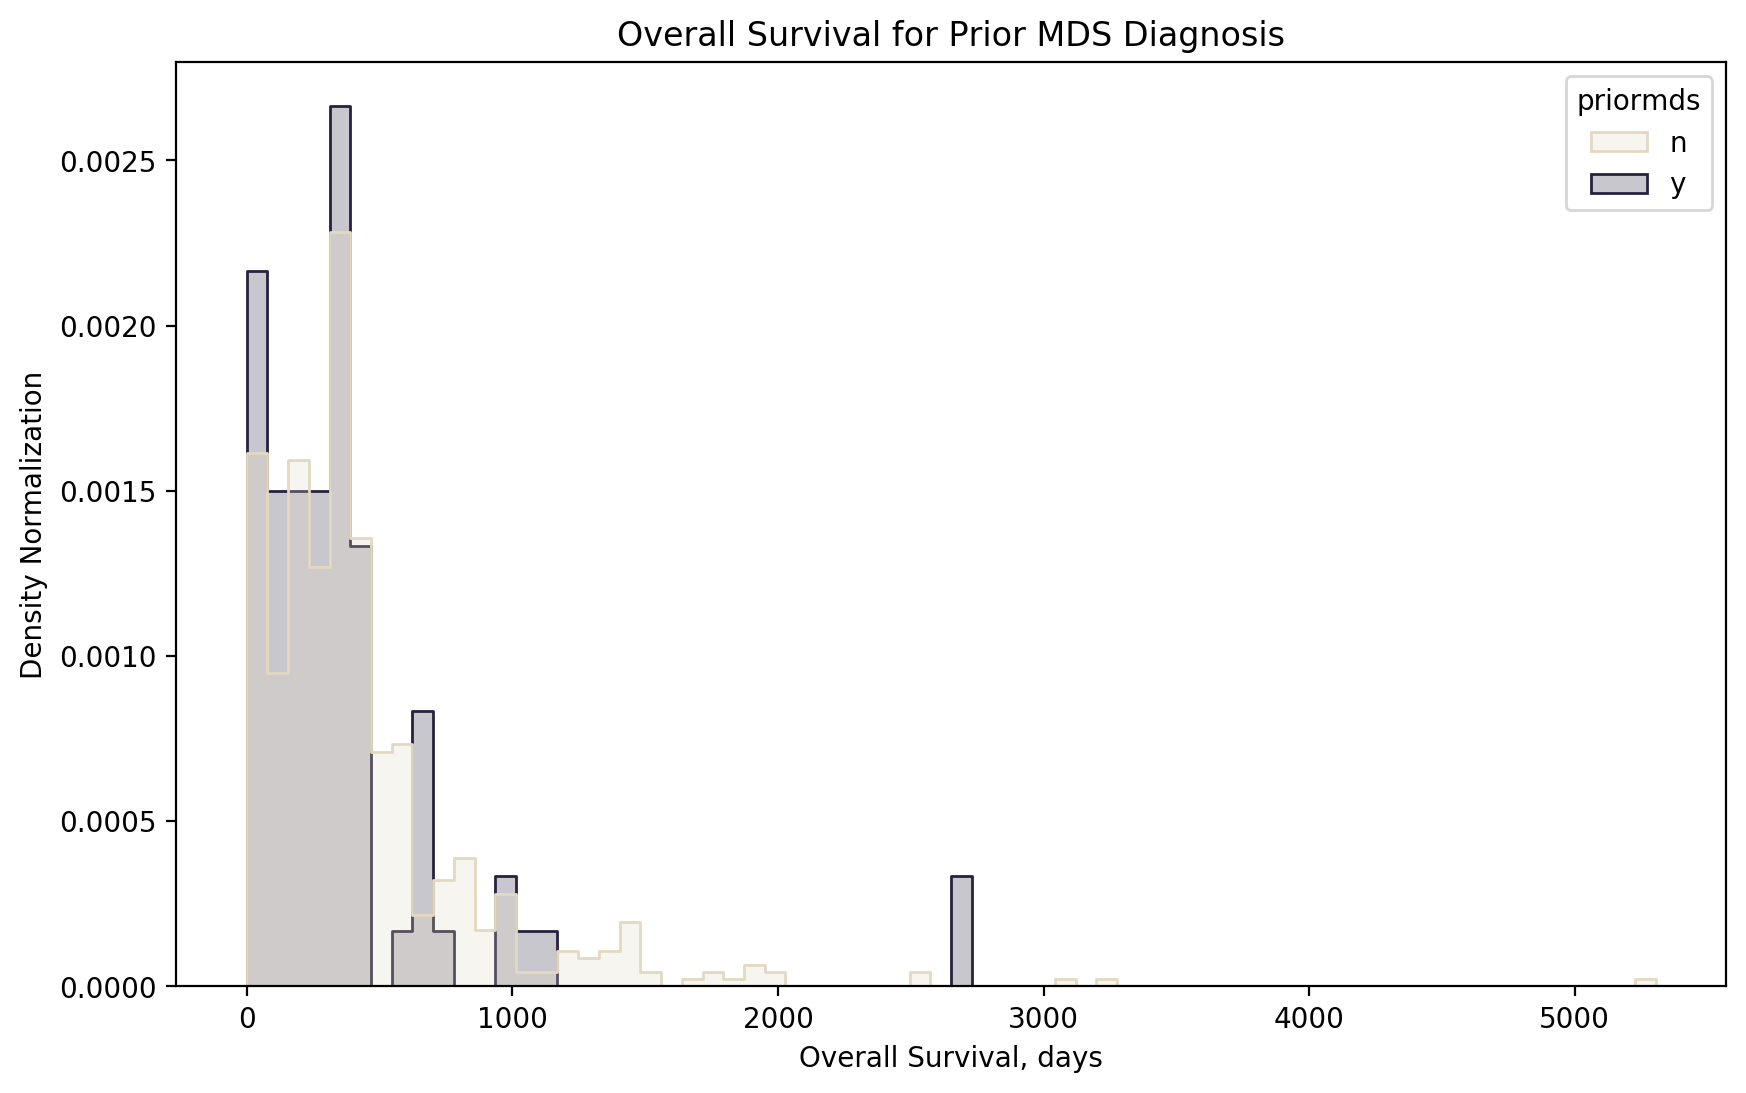

In [82]:
sns.histplot(data=clsm_cut, x="overallsurvival", hue="priormds", element="step", palette = "ch:s=-.2,r=.6", 
            stat="density", common_norm=False)
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Overall Survival, days')
plt.ylabel('Density Normalization')
#plt.legend(loc='upper right', title = 'Prior MDS Diagnosis')
plt.title("Overall Survival for Prior MDS Diagnosis")

Text(0.5, 1.0, 'Overall Survival for Relapsed Patient')

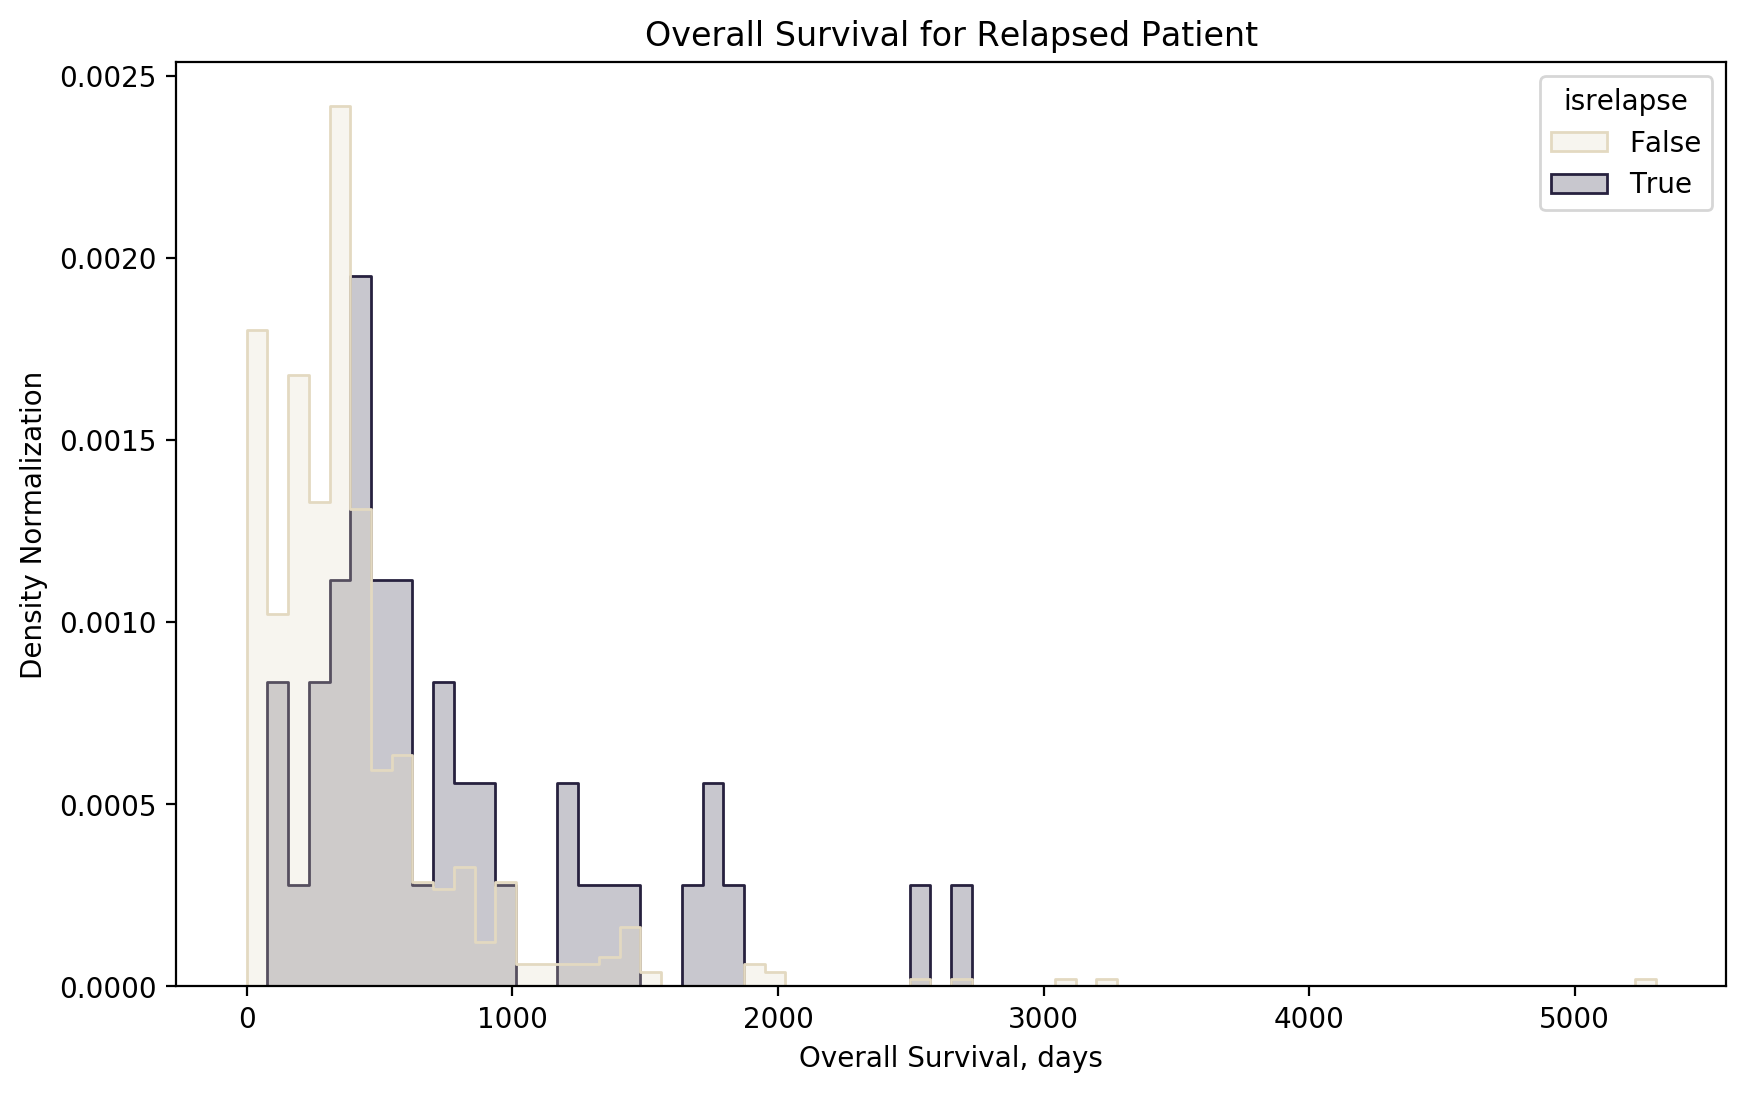

In [83]:
sns.histplot(data=clsm_cut, x="overallsurvival", hue="isrelapse", element="step", palette = "ch:s=-.2,r=.6", 
            stat="density", common_norm=False)
plt.gcf().set_size_inches(10, 6)
plt.xlabel('Overall Survival, days')
plt.ylabel('Density Normalization')
#plt.legend(loc='upper right', title = 'Prior MDS Diagnosis')
plt.title("Overall Survival for Relapsed Patient")

# New Dataframe For SageMaker JumpStart Regression Model

Transform select categorical attributes to numerical:

In [84]:
#AML_detected
clsm_cut['AML_detected'].replace(['no', 'yes'],
                        [0, 1], inplace=True)

#npm1
clsm_cut['npm1'].replace(['negative', 'positive'],
                        [0, 1], inplace=True)

#flt3-itd
clsm_cut['flt3-itd'].replace(['negative', 'positive'],
                        [0, 1], inplace=True)

#priormalignancynonmyeloid
clsm_cut['priormalignancynonmyeloid'].replace(['n', 'y'],
                        [0, 1], inplace=True)

#priormds
clsm_cut['priormds'].replace(['y', 'n'],
                        [1, 0], inplace=True)

#priormdsmpn
clsm_cut['priormdsmpn'].replace(['n', 'y'],
                        [0, 1], inplace=True)

#priormpn
clsm_cut['priormpn'].replace(['n', 'y'],
                        [0, 1], inplace=True)

#isrelapse
clsm_cut['isrelapse'].replace(['False', 'True'],
                        [0, 1], inplace=True)

#istransformed
clsm_cut['istransformed'].replace(['True', 'False'],
                        [1, 0], inplace=True)

In [85]:
clsm_t = pd.DataFrame(clsm_cut[['AML_detected', 'npm1', 'flt3-itd', 'isrelapse', 'istransformed',
                                'priormalignancynonmyeloid', 'priormds', 'priormdsmpn', 'priormpn',
                                '%.blasts.in.pb', '%.blasts.in.bm', 'overallsurvival']])

In [86]:
#Transform data type:
clsm_t['npm1'] = clsm_cut['npm1'].astype(int)
clsm_t['flt3-itd'] = clsm_cut['flt3-itd'].astype(int)

clsm_t['isrelapse'] = clsm_cut['isrelapse'].astype(int)
clsm_t['istransformed'] = clsm_cut['istransformed'].astype(int)

#### New clsm Dataframe Correlation Matrix

In [87]:
clsm_t.corr()

,AML_detected,npm1,flt3-itd,isrelapse,istransformed,priormalignancynonmyeloid,priormds,priormdsmpn,priormpn,%.blasts.in.pb,%.blasts.in.bm,overallsurvival
AML_detected,1.000000,0.098997,0.077525,0.054383,0.089238,-7.245182e-02,-2.912038e-01,-0.127707,-0.057154,0.155752,0.265724,-0.022216
npm1,0.098997,1.000000,0.333543,0.140481,-0.148233,-1.257739e-02,-1.771024e-01,-0.019763,-0.059377,0.174675,0.201114,-0.006728
flt3-itd,0.077525,0.333543,1.000000,0.107818,-0.092782,-7.228395e-02,-1.272762e-01,0.022049,-0.054524,0.271851,0.242420,-0.008150
isrelapse,0.054383,0.140481,0.107818,1.000000,-0.072971,-9.623173e-03,-6.051426e-02,-0.020414,-0.037020,0.020293,0.069284,0.210147
istransformed,0.089238,-0.148233,-0.092782,-0.072971,1.000000,-5.562376e-02,6.200179e-01,0.346275,0.472862,-0.141930,-0.128224,-0.113017
priormalignancynonmyeloid,-0.072452,-0.012577,-0.072284,-0.009623,-0.055624,1.000000e+00,-1.056121e-17,-0.009821,-0.019139,0.022151,-0.054026,-0.048934
priormds,-0.291204,-0.177102,-0.127276,-0.060514,0.620018,-1.056121e-17,1.000000e+00,-0.044057,-0.042272,-0.173911,-0.201517,-0.044667
priormdsmpn,-0.127707,-0.019763,0.022049,-0.020414,0.346275,-9.820928e-03,-4.405654e-02,1.000000,-0.045111,-0.103580,-0.087142,-0.106423
priormpn,-0.057154,-0.059377,-0.054524,-0.037020,0.472862,-1.913898e-02,-4.227151e-02,-0.045111,1.000000,-0.061838,-0.105951,-0.000754
%.blasts.in.pb,0.155752,0.174675,0.271851,0.020293,-0.141930,2.215108e-02,-1.739113e-01,-0.103580,-0.061838,1.000000,0.563923,-0.059324


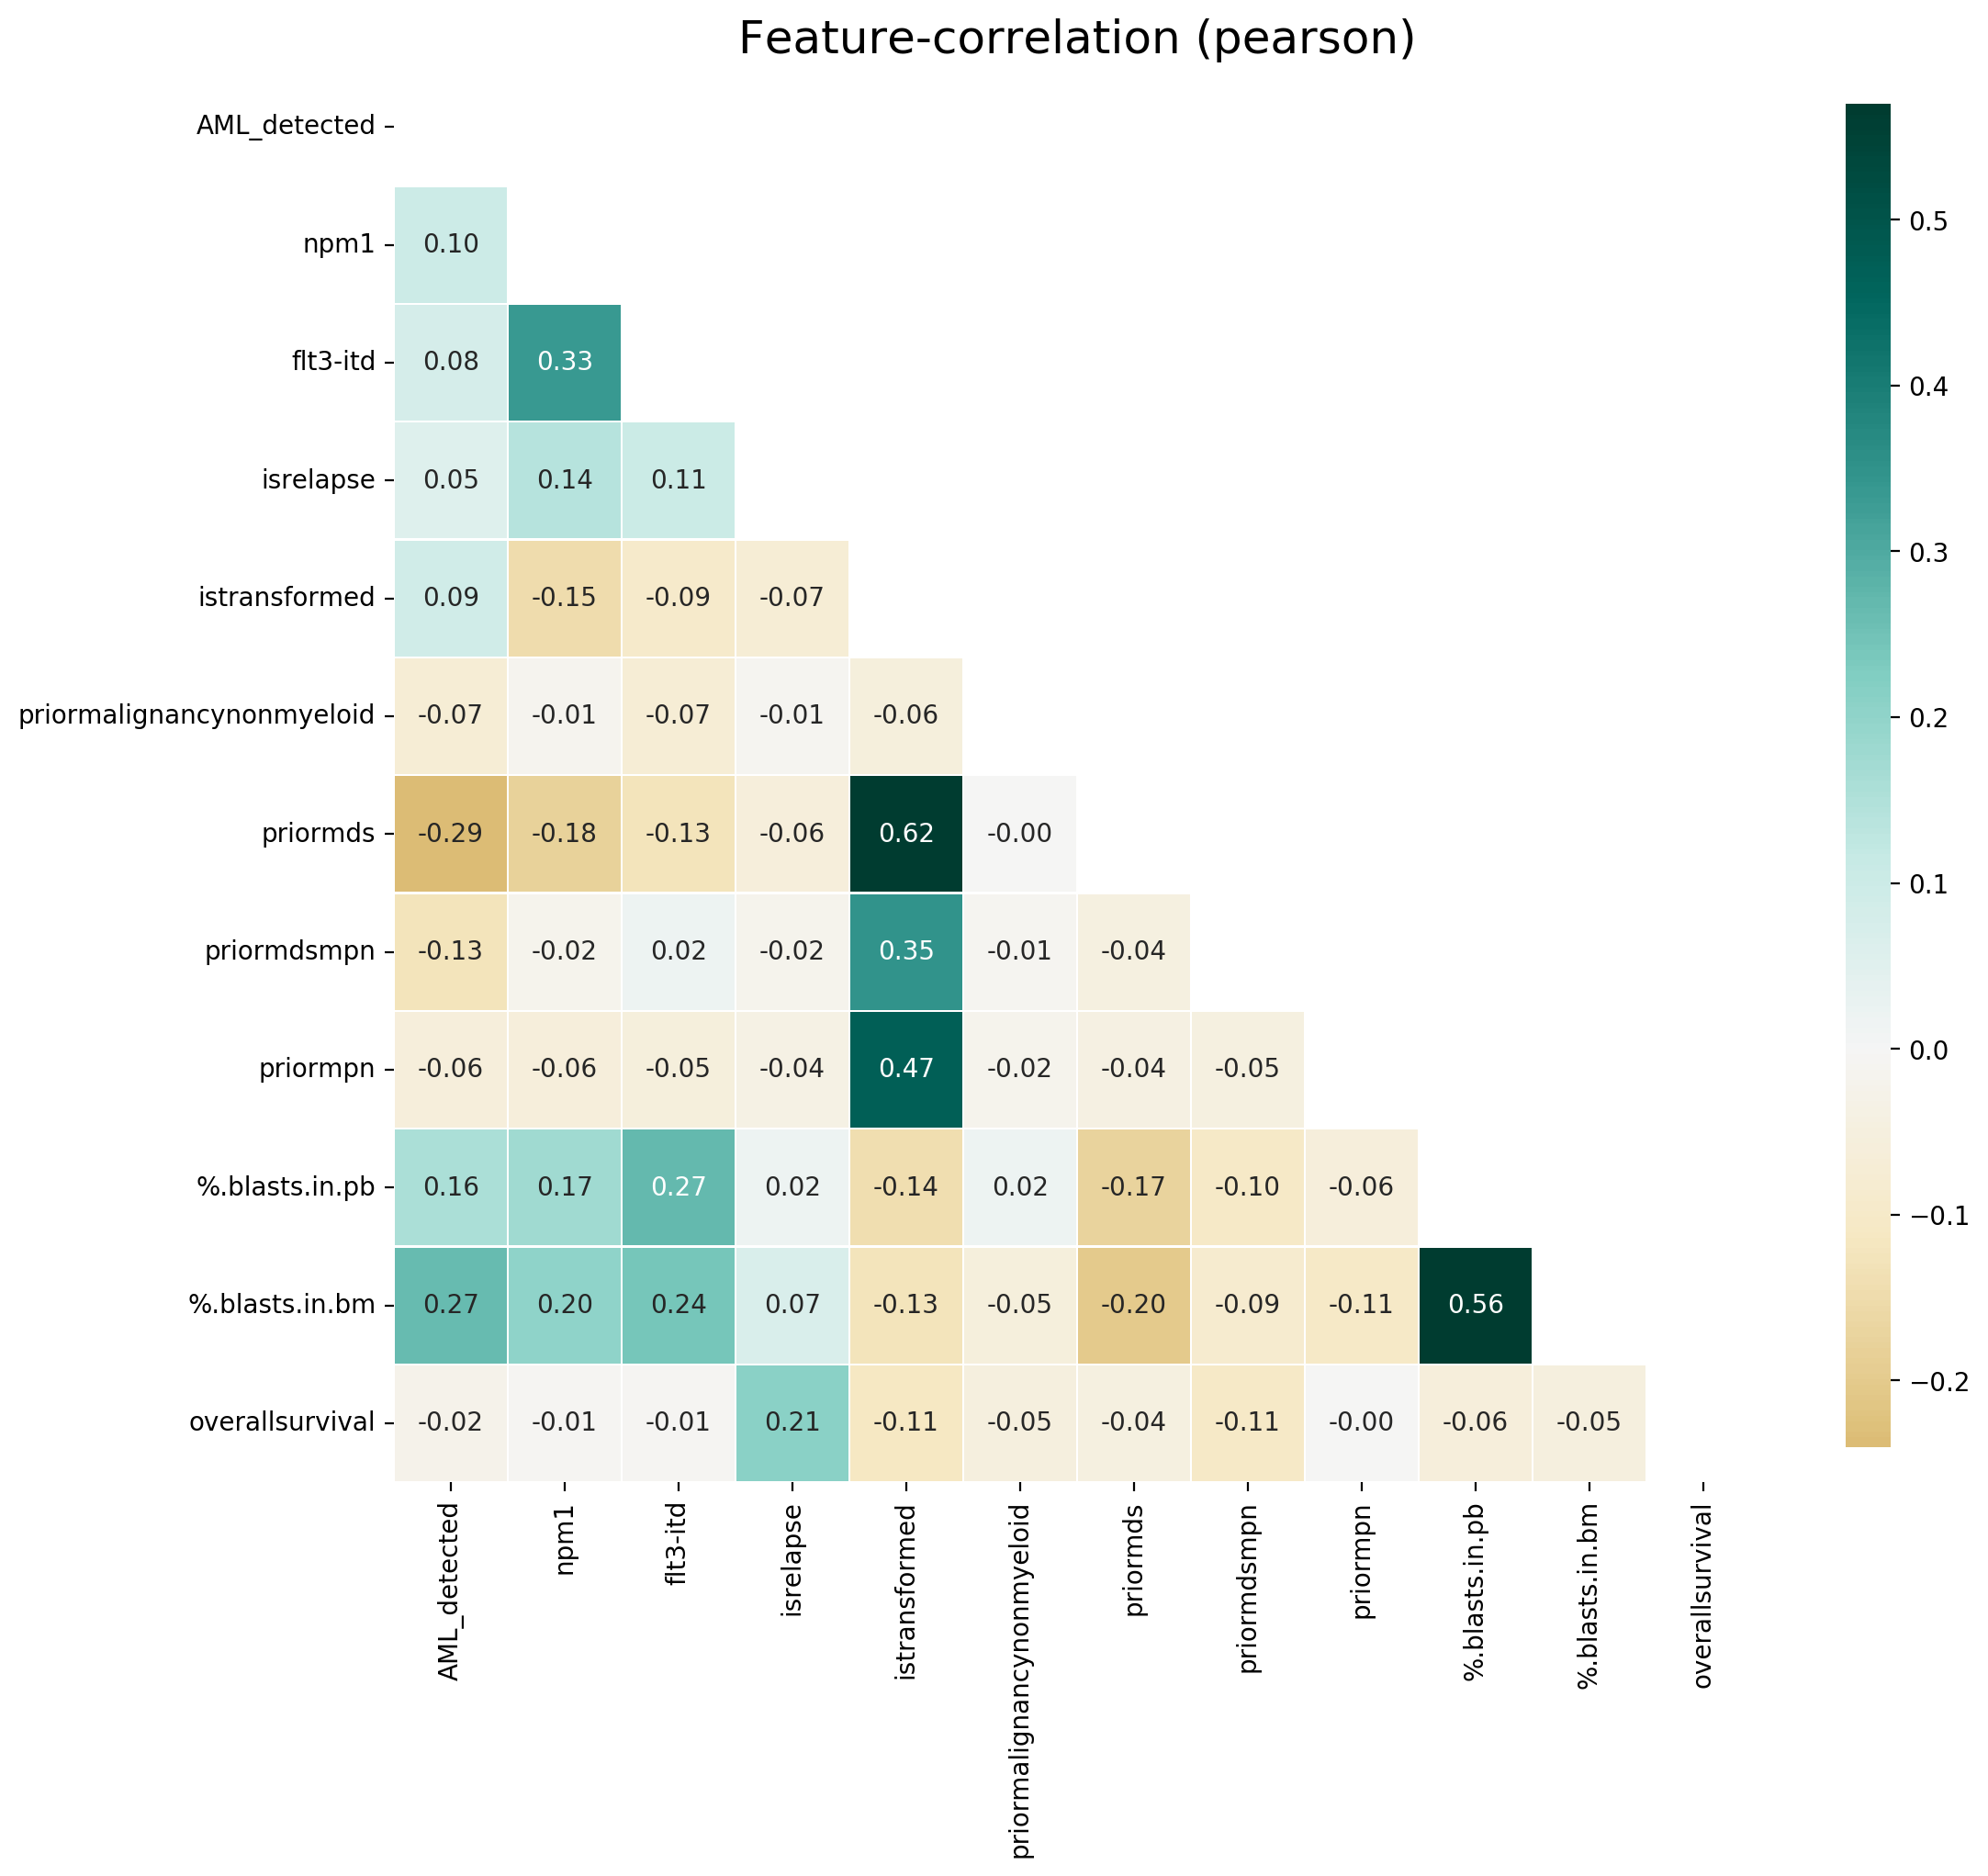

In [88]:
klib.corr_plot(clsm_t)

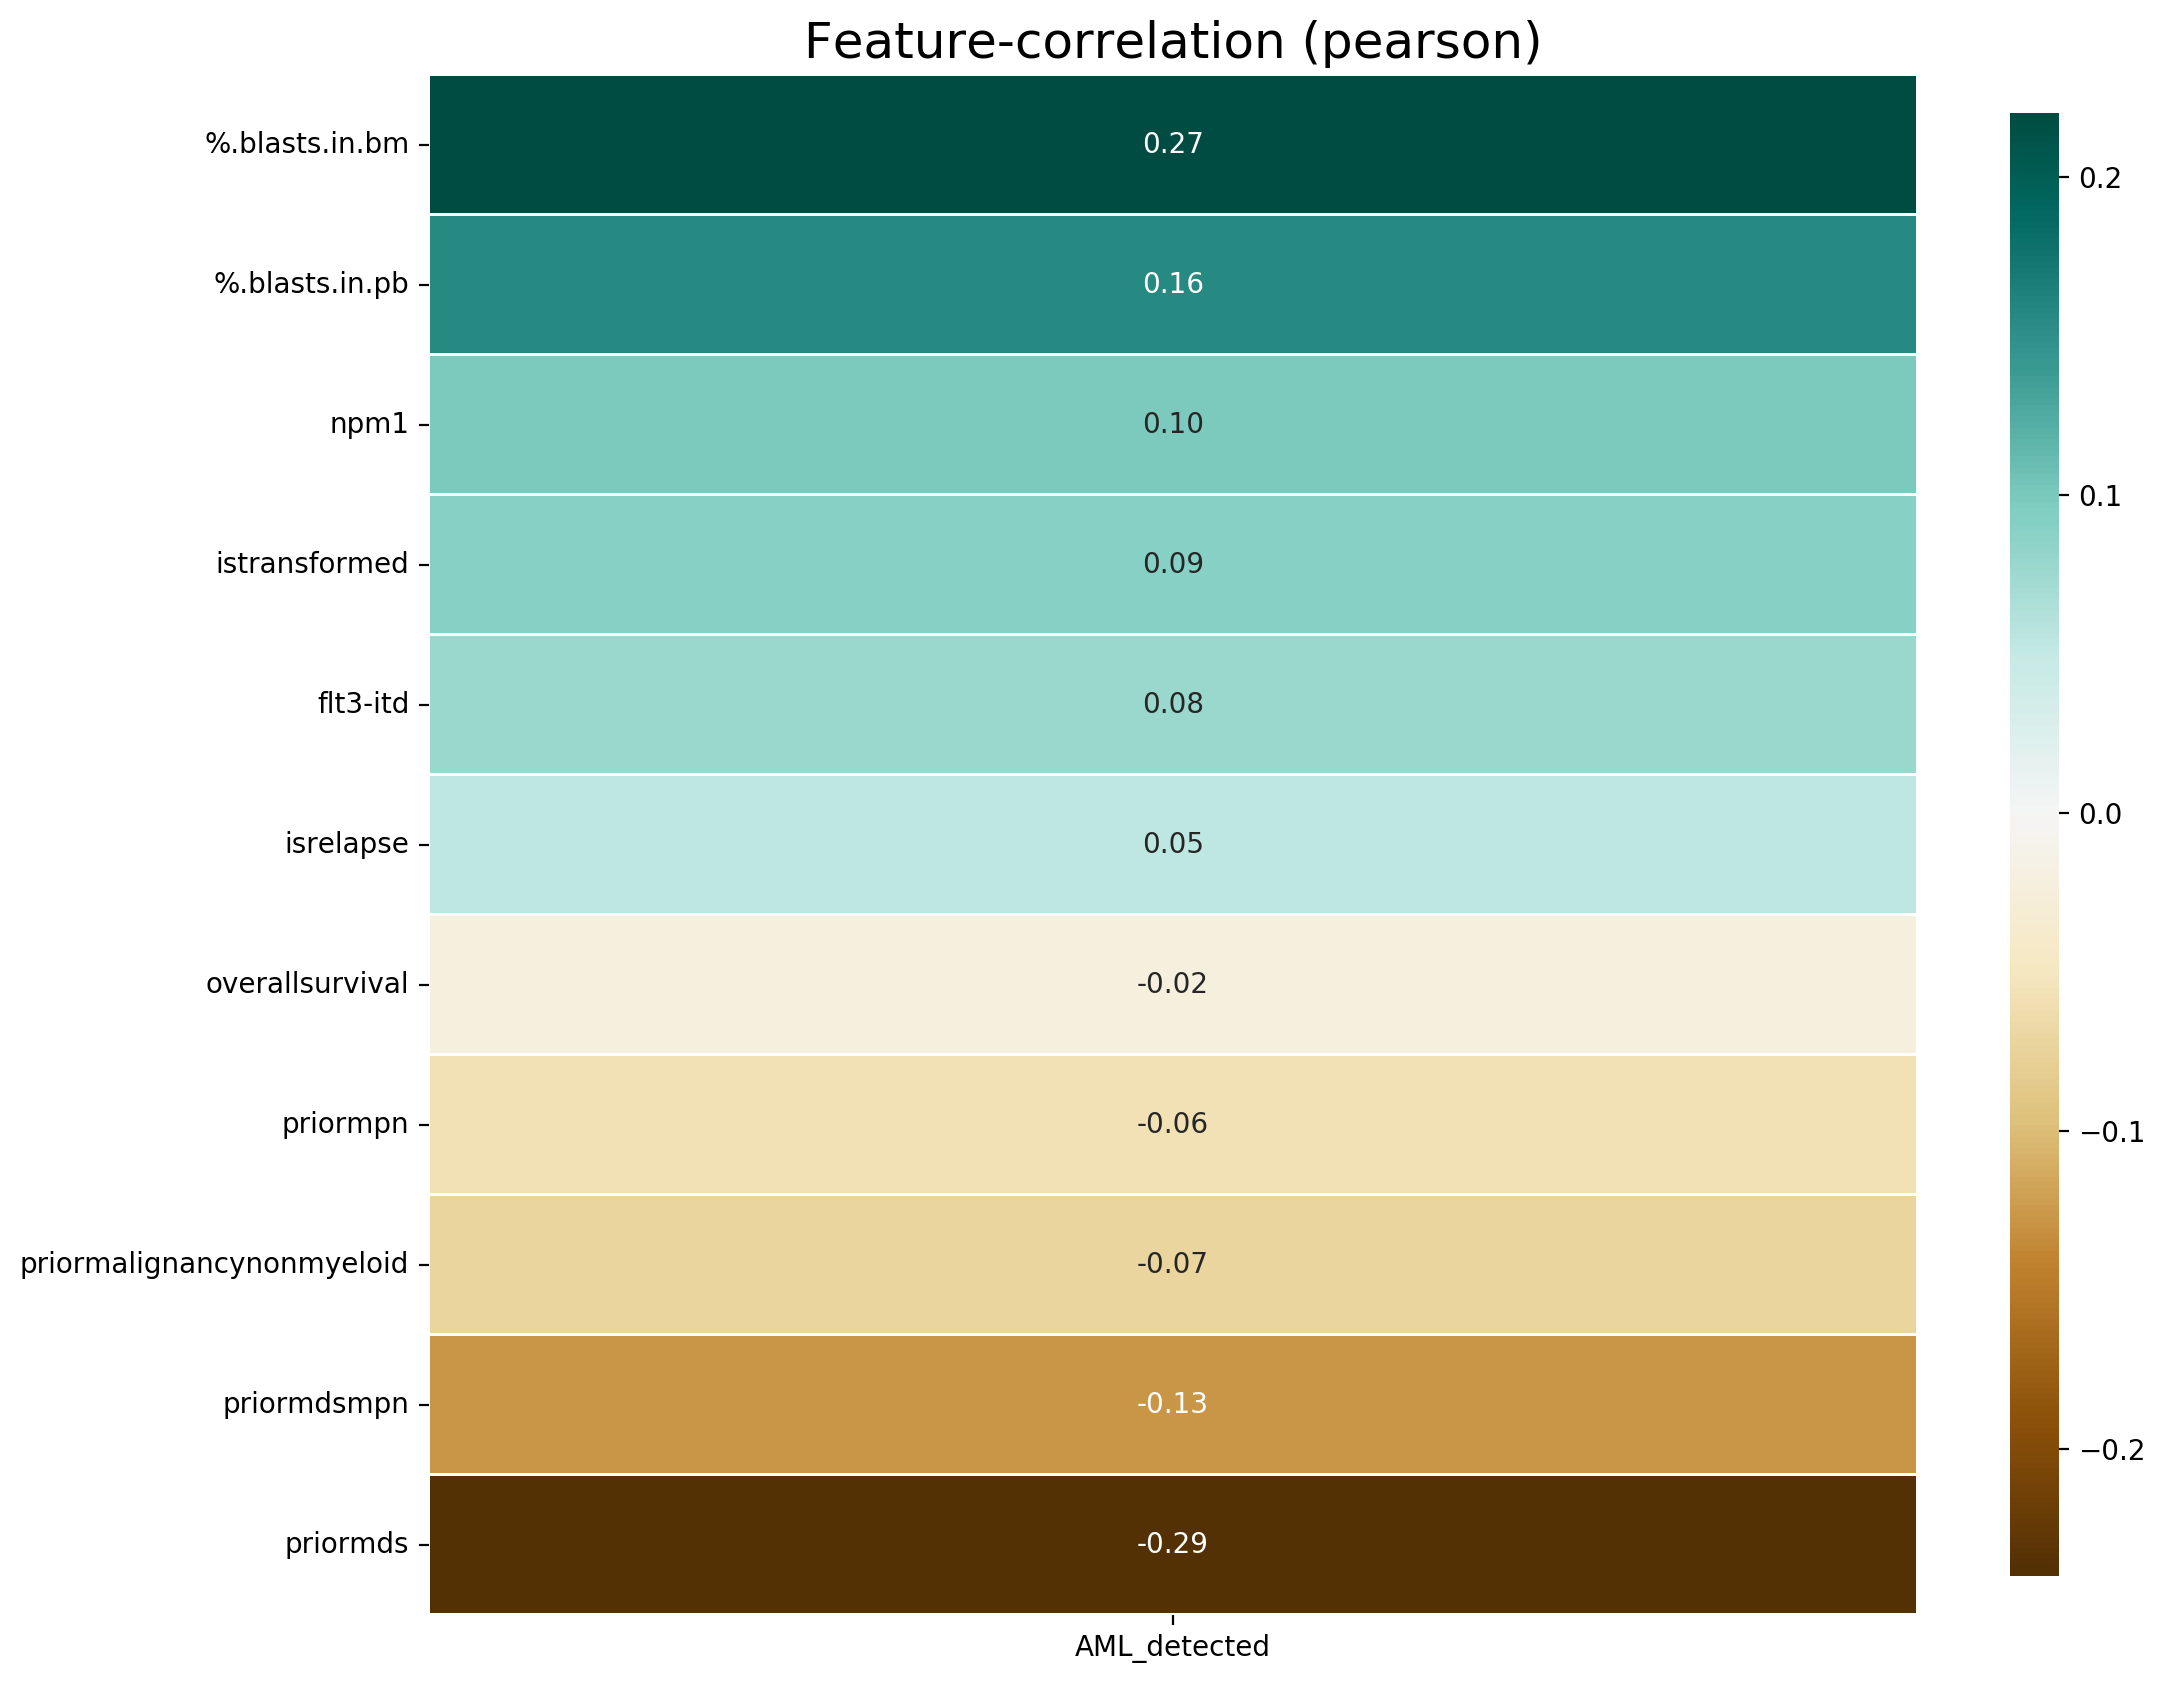

In [89]:
klib.corr_plot(clsm_t, target='AML_detected')

#### One-Hot encoding

In [90]:
clsm_t = pd.get_dummies(clsm_t, columns= ['npm1', 'flt3-itd', 'priormalignancynonmyeloid', 
                                                  'priormds', 'priormdsmpn', 'priormpn', 'isrelapse', 'istransformed'])

In [91]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AML_detected                 672 non-null    int64  
 1   %.blasts.in.pb               672 non-null    float64
 2   %.blasts.in.bm               672 non-null    float64
 3   overallsurvival              672 non-null    float64
 4   npm1_0                       672 non-null    uint8  
 5   npm1_1                       672 non-null    uint8  
 6   flt3-itd_0                   672 non-null    uint8  
 7   flt3-itd_1                   672 non-null    uint8  
 8   priormalignancynonmyeloid_0  672 non-null    uint8  
 9   priormalignancynonmyeloid_1  672 non-null    uint8  
 10  priormds_0                   672 non-null    uint8  
 11  priormds_1                   672 non-null    uint8  
 12  priormdsmpn_0                672 non-null    uint8  
 13  priormdsmpn_1       

In [92]:
clsm_t.head()

,AML_detected,%.blasts.in.pb,%.blasts.in.bm,overallsurvival,npm1_0,npm1_1,flt3-itd_0,flt3-itd_1,priormalignancynonmyeloid_0,priormalignancynonmyeloid_1,priormds_0,priormds_1,priormdsmpn_0,priormdsmpn_1,priormpn_0,priormpn_1,isrelapse_0,isrelapse_1,istransformed_0,istransformed_1
0,1,97.0,94.0,425.0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0
1,1,19.0,80.0,419.0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0
2,1,99.0,91.0,541.0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0
3,1,97.0,97.0,511.0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0
4,1,80.0,87.0,419.0,1,0,0,1,1,0,1,0,1,0,1,0,0,1,1,0


#### Transform Headers

In [93]:
clsm_t = clsm_t.rename(columns={ '%.blasts.in.pb': 'Feature_1', '%.blasts.in.bm': 'Feature_2', 
                                           'overallsurvival': 'Feature_3', 
                                            'npm1_0': 'Feature_4', 'npm1_1': 'Feature_5', 
                                           'flt3-itd_0': 'Feature_6', 'flt3-itd_1': 'Feature_7', 
                                            'priormalignancynonmyeloid_0': 'Feature_8', 'priormalignancynonmyeloid_1': 'Feature_9', 
                                            'priormds_0': 'Feature_10', 'priormds_1': 'Feature_11', 
                                           'priormdsmpn_0': 'Feature_12', 'priormdsmpn_1': 'Feature_13', 
                                            'priormpn_0': 'Feature_14', 'priormpn_1': 'Feature_15', 
                                            'isrelapse_0': 'Feature_16', 'isrelapse_1': 'Feature_17', 
                                           'istransformed_0': 'Feature_18', 'istransformed_1': 'Feature_19' })

In [94]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AML_detected  672 non-null    int64  
 1   Feature_1     672 non-null    float64
 2   Feature_2     672 non-null    float64
 3   Feature_3     672 non-null    float64
 4   Feature_4     672 non-null    uint8  
 5   Feature_5     672 non-null    uint8  
 6   Feature_6     672 non-null    uint8  
 7   Feature_7     672 non-null    uint8  
 8   Feature_8     672 non-null    uint8  
 9   Feature_9     672 non-null    uint8  
 10  Feature_10    672 non-null    uint8  
 11  Feature_11    672 non-null    uint8  
 12  Feature_12    672 non-null    uint8  
 13  Feature_13    672 non-null    uint8  
 14  Feature_14    672 non-null    uint8  
 15  Feature_15    672 non-null    uint8  
 16  Feature_16    672 non-null    uint8  
 17  Feature_17    672 non-null    uint8  
 18  Feature_18    672 non-null    

# Save New Pre-Processed clsm Dataframe to S3

In [95]:
clsm_t.to_csv('clsm_t.csv') 

In [96]:
#Manually upload into S3
!aws s3 ls s3://team4rawdatasets/CSV/Input/

                           PRE OHSU_BeatAML_ClinicalSummary/
                           PRE OpenCell_ProteinInteraction/
2023-03-21 01:19:41          0 
2023-04-12 05:44:22      30850 clsm_t.csv


In [97]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/team4rawdatasets?region=us-east-1&prefix=CSV/Input/&showversions=false">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# Split the Data into Train, Test, and Validation sets

In [98]:
clsm_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AML_detected  672 non-null    int64  
 1   Feature_1     672 non-null    float64
 2   Feature_2     672 non-null    float64
 3   Feature_3     672 non-null    float64
 4   Feature_4     672 non-null    uint8  
 5   Feature_5     672 non-null    uint8  
 6   Feature_6     672 non-null    uint8  
 7   Feature_7     672 non-null    uint8  
 8   Feature_8     672 non-null    uint8  
 9   Feature_9     672 non-null    uint8  
 10  Feature_10    672 non-null    uint8  
 11  Feature_11    672 non-null    uint8  
 12  Feature_12    672 non-null    uint8  
 13  Feature_13    672 non-null    uint8  
 14  Feature_14    672 non-null    uint8  
 15  Feature_15    672 non-null    uint8  
 16  Feature_16    672 non-null    uint8  
 17  Feature_17    672 non-null    uint8  
 18  Feature_18    672 non-null    

In [99]:
from sklearn.model_selection import train_test_split

# Split all data into 80% train and 20% holdout
clsm_train, clsm_holdout = train_test_split(clsm_t, test_size=0.20, random_state=42)

# Split holdout data into 50% validation and 50% test
clsm_validation, clsm_test = train_test_split(clsm_holdout, test_size=0.50, random_state=42)

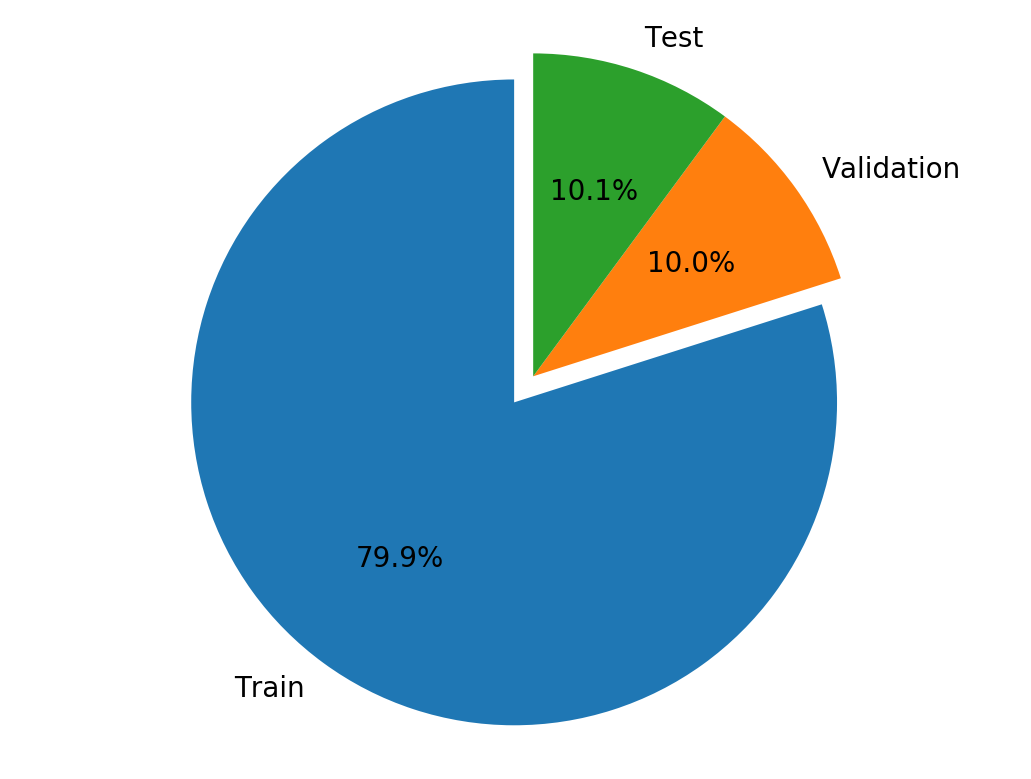

In [100]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = ["Train", "Validation", "Test"]
sizes = [len(clsm_train.index), len(clsm_validation.index), len(clsm_test.index)]
explode = (0.1, 0, 0)

fig1, ax1 = plt.subplots()

ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", startangle=90)

# Equal aspect ratio ensures that pie is drawn as a circle.
ax1.axis("equal")

plt.show()

### Show 80% Train Data Split

In [101]:
clsm_train.shape

(537, 20)

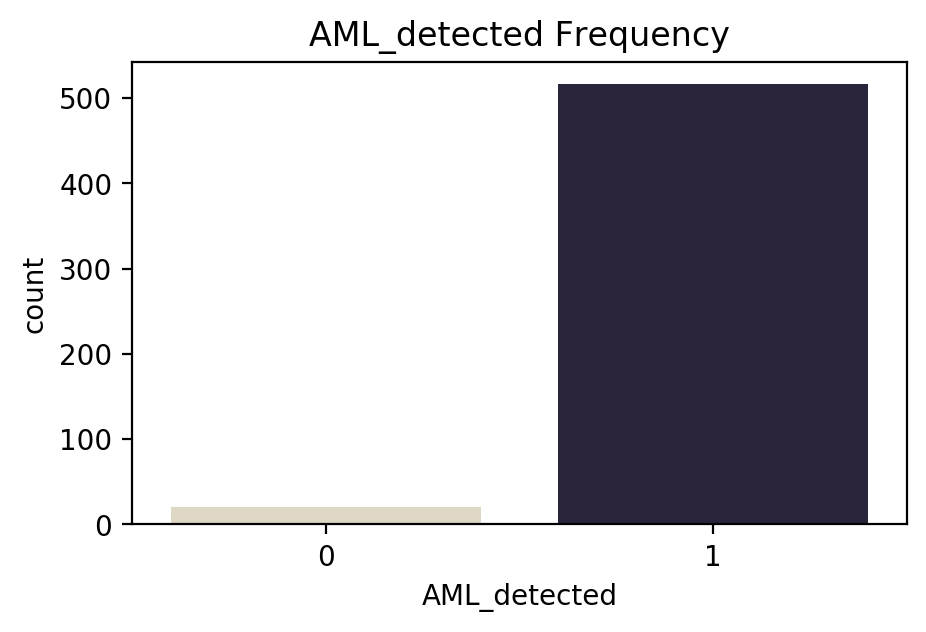

In [102]:
sns.countplot(x=clsm_train["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

### Show 10% Validation Data Split

In [103]:
clsm_validation.shape

(67, 20)

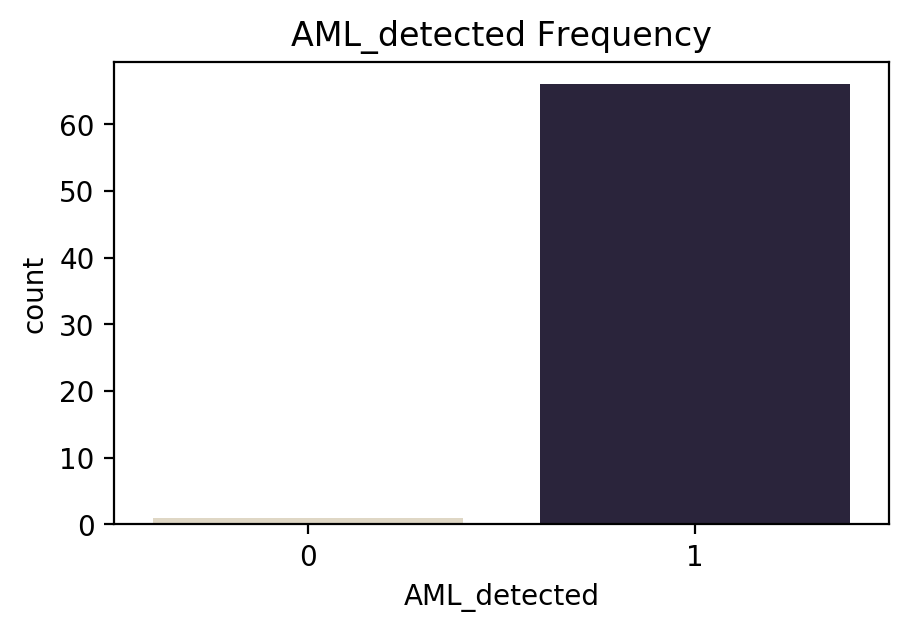

In [104]:
sns.countplot(x=clsm_validation["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

In [105]:
clsm_validation.to_csv('clsm_validation_.csv') 

In [106]:
#Manually upload into S3
!aws s3 ls s3://clsm/tabular_regressonehot/

                           PRE output/
                           PRE test/
                           PRE train/
                           PRE validation/
2023-04-11 01:26:47          0 


In [107]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/clsm?prefix=tabular_regressonehot/&region=us-east-1">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

### Show 10% Test Data Split

In [108]:
clsm_test.shape

(68, 20)

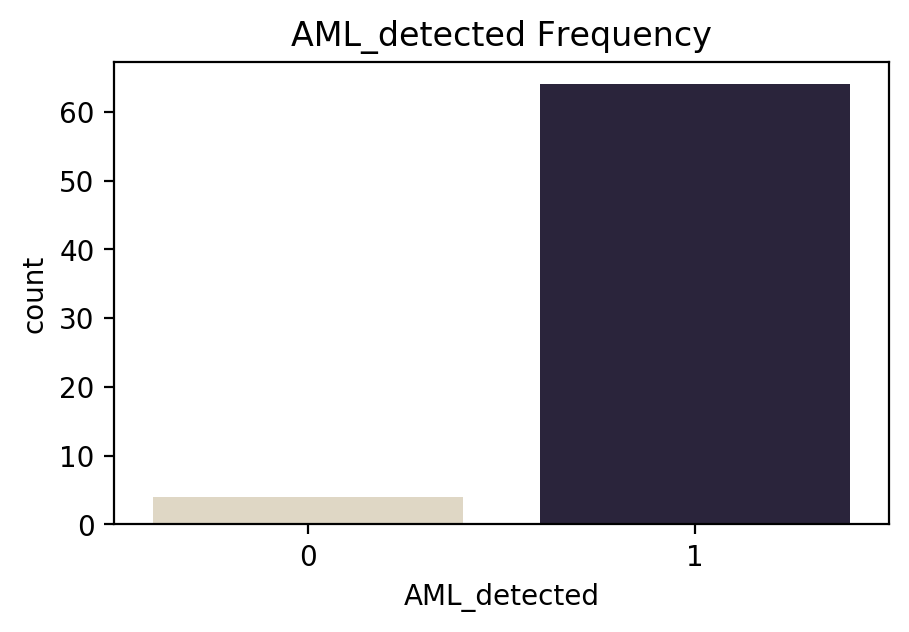

In [109]:
sns.countplot(x=clsm_test["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

In [110]:
clsm_test.to_csv('clsm_test_.csv') 

In [111]:
#Manually upload into S3
!aws s3 ls s3://clsm/tabular_regressonehot/

                           PRE output/
                           PRE test/
                           PRE train/
                           PRE validation/
2023-04-11 01:26:47          0 


In [112]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/clsm?prefix=tabular_regressonehot/&region=us-east-1">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# Balance Training Dataset

### Training Dataset:

In [113]:
clsm_train["AML_detected"].value_counts()

1    516
0     21
Name: AML_detected, dtype: int64

Balancing Equation:
n = [p(records)-rare]/(1-p), where p=0.50, records=537, rare=21.

In [114]:
#resampling of training data set
to_resample= clsm_train.loc[clsm_train["AML_detected"] == 0] #isolate all records of AML_detected
our_resample=to_resample.sample(n=495, replace=True) #sample w/ replacement
clsm_t_rebal=pd.concat([clsm_train, our_resample]) #combine original training set w/ resampled records
clsm_t_rebal["AML_detected"].value_counts()

1    516
0    516
Name: AML_detected, dtype: int64

In [115]:
clsm_t_rebal.shape

(1032, 20)

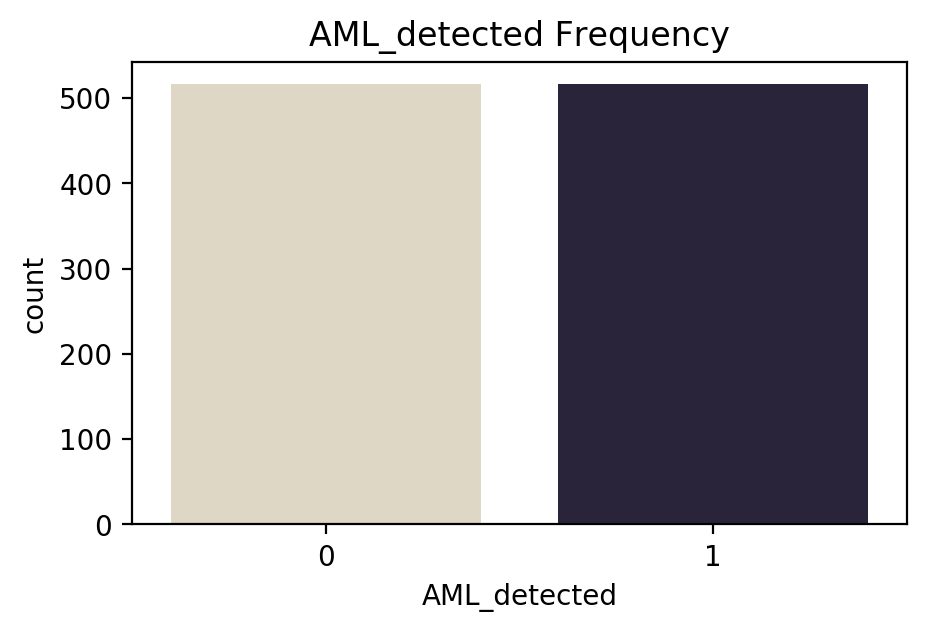

In [116]:
sns.countplot(x=clsm_t_rebal["AML_detected"], palette = "ch:s=-.2,r=.6")
plt.xlabel('AML_detected')
plt.title('AML_detected Frequency')
plt.gcf().set_size_inches(5, 3)

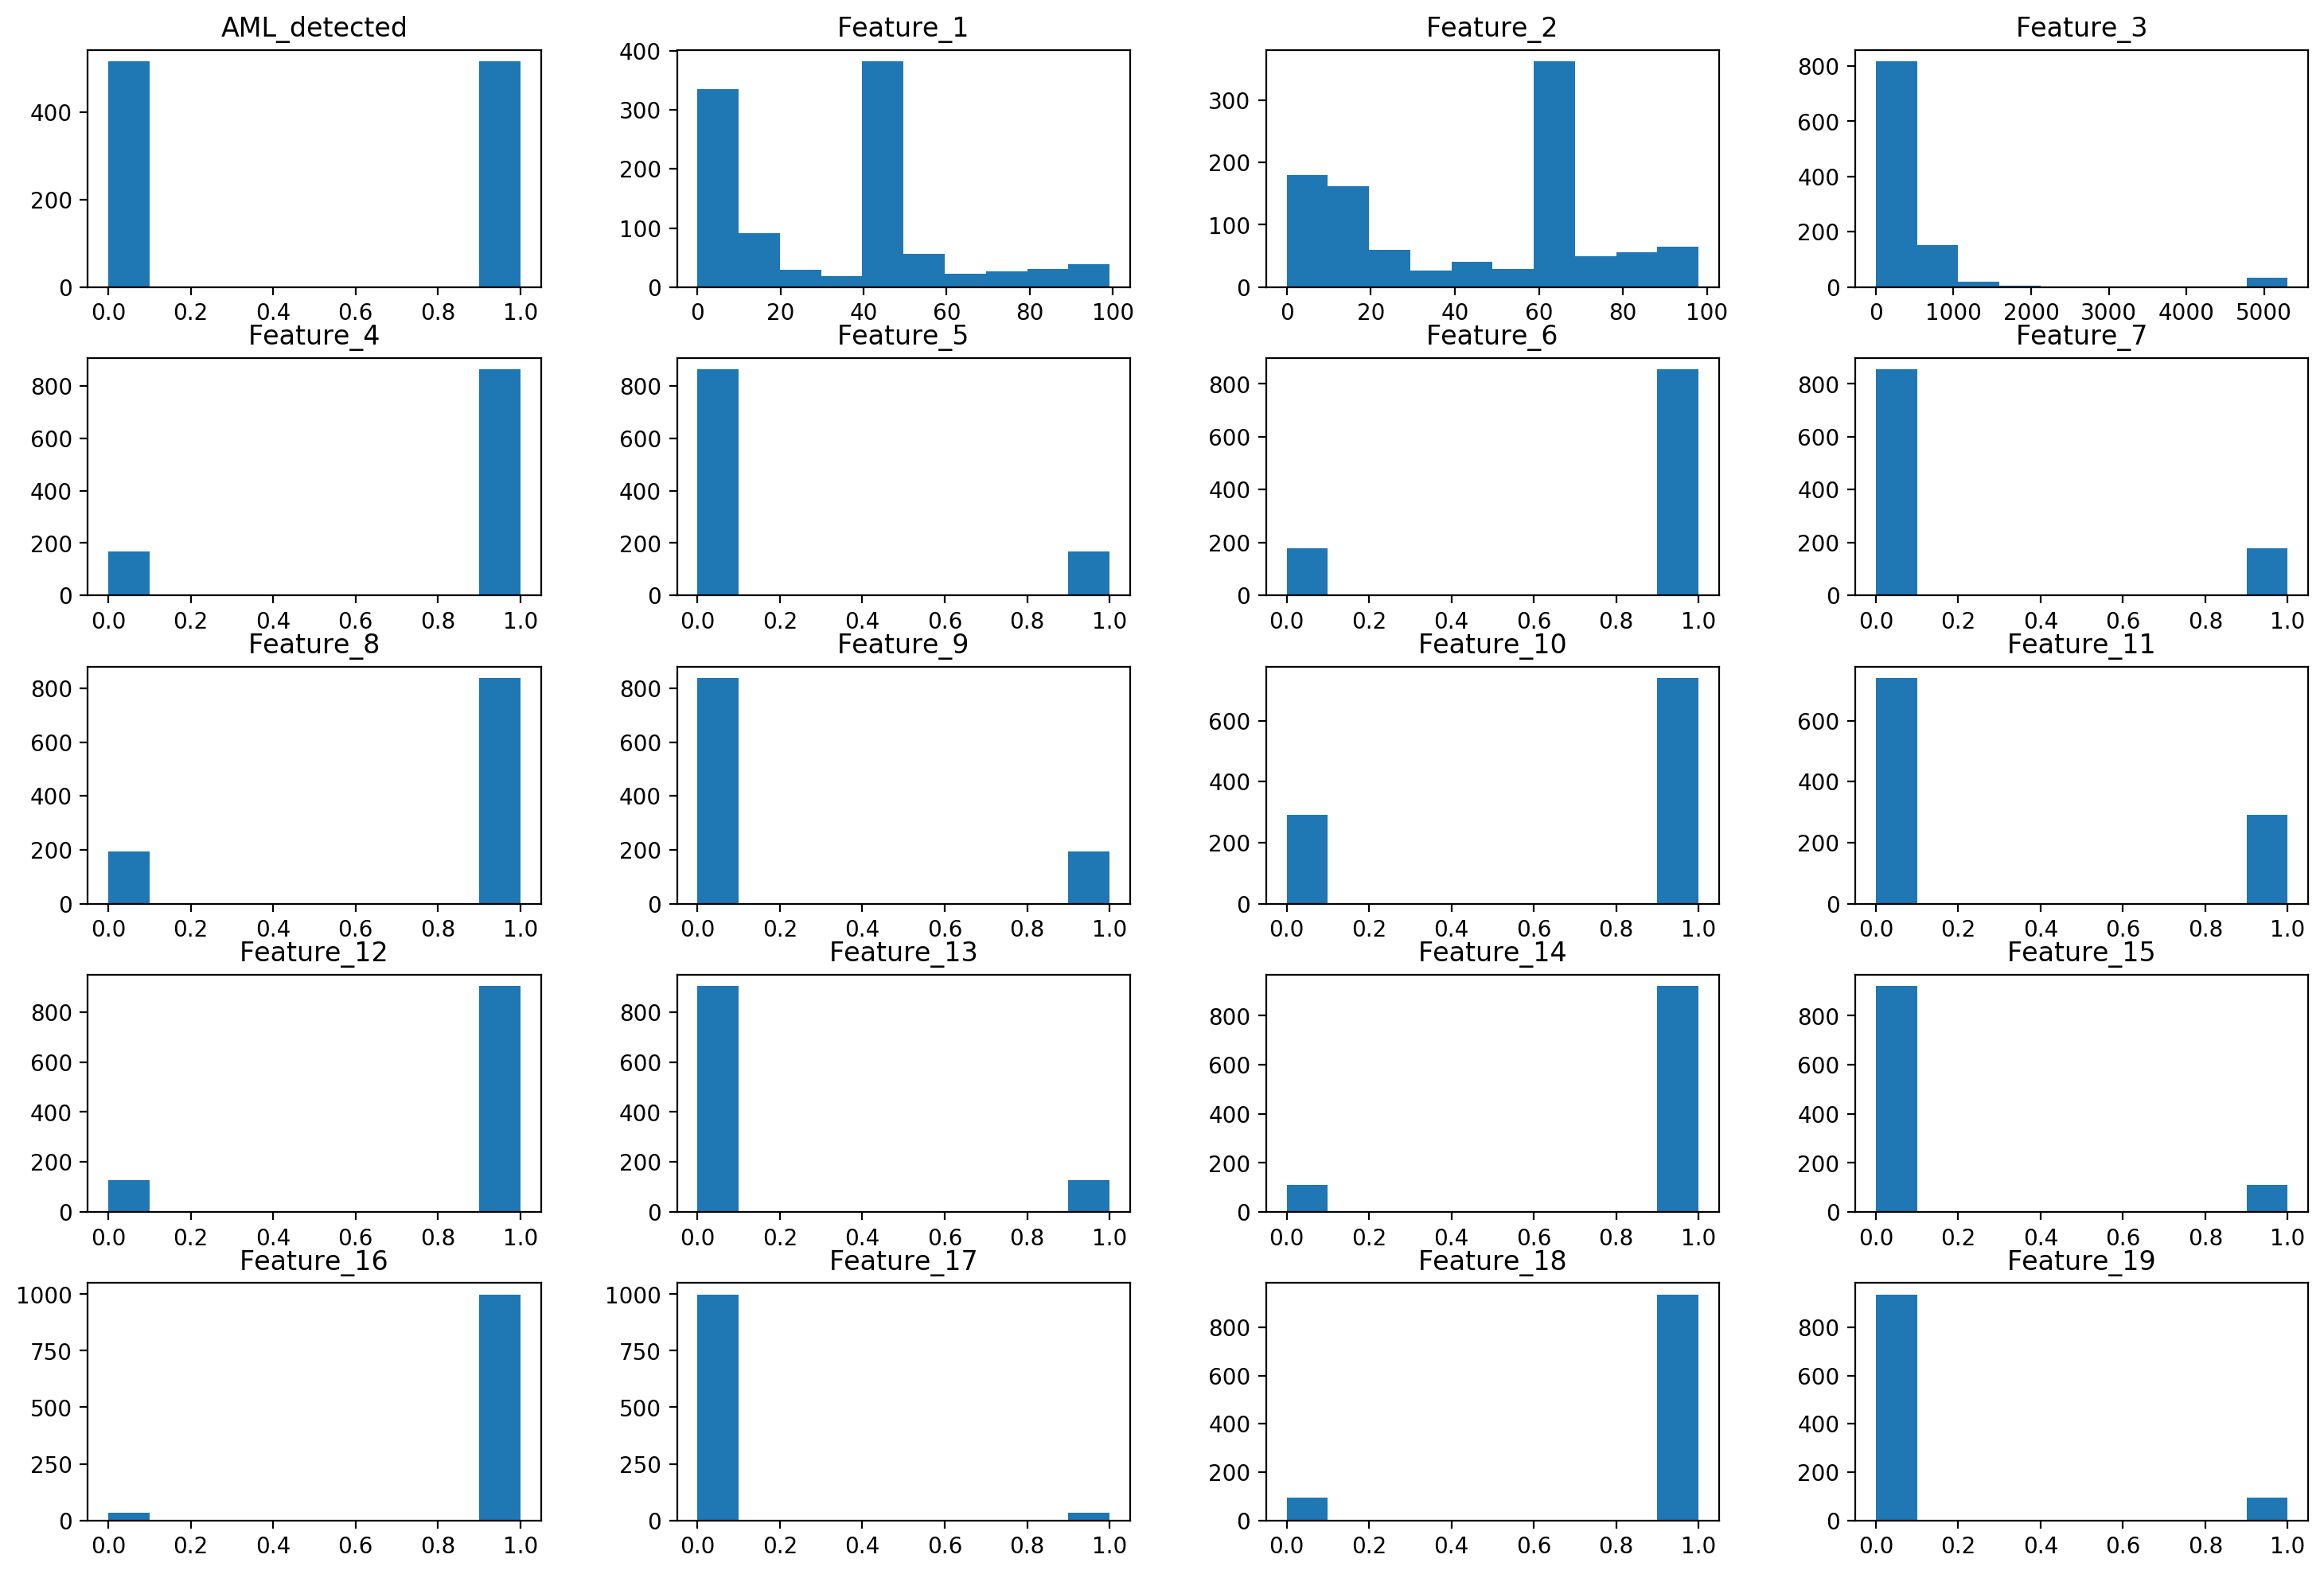

In [117]:
#clsm_t_rebal Distribution
clsm_t_rebal.hist(grid=False, figsize=(18,12))
plt.show()

In [118]:
clsm_t_rebal.head()

,AML_detected,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19
480,1,95.0,95.0,201.0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
605,1,57.0,40.0,179.0,0,1,1,0,0,1,1,0,1,0,1,0,1,0,1,0
61,1,41.5,63.0,1993.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
145,1,16.0,63.0,323.0,1,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1
353,1,0.0,30.0,323.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [119]:
clsm_t_rebal.to_csv('clsm_t_rebal_.csv') 

In [120]:
#Manually upload into S3
!aws s3 ls s3://clsm/tabular_regressonehot/

                           PRE output/
                           PRE test/
                           PRE train/
                           PRE validation/
2023-04-11 01:26:47          0 


In [121]:
display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/clsm?prefix=tabular_regressonehot/&region=us-east-1">S3 Output Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

# SageMaker JumpStart: XGBoost Model

### Set-Up

In [122]:
!pip install ipywidgets==7.0.0 --quiet


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


In [123]:
import json
from sagemaker.session import Session

sagemaker_session = Session()
aws_role = sagemaker_session.get_caller_identity_arn()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

###  Retrieve Training Artifacts

In [124]:
model_id, model_version = "xgboost-regression-model", "*"

In [125]:
from ipywidgets import Dropdown
from sagemaker.jumpstart.notebook_utils import list_jumpstart_models
from sagemaker.jumpstart.filters import And

# Retrieves all xgboost and sklearn regression models available by SageMaker Built-In Algorithms.
filter_value = And(f"framework in ['xgboost', 'sklearn']", "task == regression")
text_embedding_models = list_jumpstart_models(filter=filter_value)

# display the model-ids in a dropdown to select a model for inference.
model_dropdown = Dropdown(
    options=text_embedding_models,
    value=model_id,
    description="Select a model",
    style={"description_width": "initial"},
    layout={"width": "max-content"},
)

### Chose a model for training

In [126]:
display(model_dropdown)

A Jupyter Widget

In [127]:
from sagemaker import image_uris, model_uris, script_uris

train_model_id, train_model_version, train_scope = model_dropdown.value, "*", "training"
training_instance_type = "ml.m5.xlarge"

# Retrieve the docker image
train_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    model_id=train_model_id,
    model_version=train_model_version,
    image_scope=train_scope,
    instance_type=training_instance_type,
)
# Retrieve the training script
train_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope=train_scope
)
# Retrieve the pre-trained model tarball to further fine-tune
train_model_uri = model_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, model_scope=train_scope
)

### Set Training Parameters

In [128]:
# Sample training data is available in this bucket
training_dataset_s3_path = "s3://clsm/tabular_regressonehot/"

s3_output_location = "s3://clsm/tabular_regressonehot/output/"

In [129]:
from sagemaker import hyperparameters

# Retrieve the default hyper-parameters for fine-tuning the model
hyperparameters = hyperparameters.retrieve_default(
    model_id=train_model_id, model_version=train_model_version
)

# [Optional] Override default hyperparameters with custom values
hyperparameters["num_boost_round"] = "500"
hyperparameters["reg_lambda"] = "3"
print(hyperparameters)

{'num_boost_round': '500', 'early_stopping_rounds': '30', 'learning_rate': '0.3', 'gamma': '0', 'min_child_weight': '1', 'max_depth': '6', 'subsample': '1', 'colsample_bytree': '1', 'reg_lambda': '3', 'reg_alpha': '0'}


### Start Training

In [130]:
from sagemaker.estimator import Estimator
from sagemaker.utils import name_from_base

training_job_name = name_from_base(f"clsm-rebal-{train_model_id}-training")

# Create SageMaker Estimator instance
tabular_estimator = Estimator(
    role=aws_role,
    image_uri=train_image_uri,
    source_dir=train_source_uri,
    model_uri=train_model_uri,
    entry_point="transfer_learning.py",
    instance_count=1,
    instance_type=training_instance_type,
    max_run=360000,
    hyperparameters=hyperparameters,
    output_path=s3_output_location,
)

# Launch a SageMaker Training job by passing s3 path of the training data
tabular_estimator.fit({"training": "s3://clsm/tabular_regressonehot/train/clsm_t_rebal_.csv",
                       "validation": "s3://clsm/tabular_regressonehot/validation/clsm_validation_.csv" }, logs=True, job_name=training_job_name)

INFO:sagemaker:Creating training-job with name: clsm-rebal-xgboost-regression-model-tra-2023-04-17-02-35-14-214


2023-04-17 02:35:18 Starting - Starting the training job...
2023-04-17 02:35:34 Starting - Preparing the instances for training...
2023-04-17 02:36:21 Downloading - Downloading input data...
2023-04-17 02:36:43 Training - Downloading the training image...
2023-04-17 02:37:24 Uploading - Uploading generated training model[2023-04-17 02:37:15.789 ip-10-0-175-156.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-04-17 02:37:15.814 ip-10-0-175-156.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-04-17:02:37:15:INFO] Imported framework sagemaker_xgboost_container.training
[2023-04-17:02:37:15:INFO] No GPUs detected (normal if no gpus installed)
[2023-04-17:02:37:15:INFO] Invoking user training script.
[2023-04-17:02:37:16:INFO] Module transfer_learning does not provide a setup.py. 
Generating setup.py
[2023-04-17:02:37:16:INFO] Generating setup.cfg
[2023-04-17:02:37:16:INFO] Generating MANIFEST.in
[2023-04-17:02:37:16:INFO] Instal

### Deploy and Run Inference on the Trained Tabular Model

In [131]:
inference_instance_type = "ml.m5.large"

# Retrieve the inference docker container uri
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope="inference",
    model_id=train_model_id,
    model_version=train_model_version,
    instance_type=inference_instance_type,
)
# Retrieve the inference script uri
deploy_source_uri = script_uris.retrieve(
    model_id=train_model_id, model_version=train_model_version, script_scope="inference"
)

endpoint_name = name_from_base(f"clsm-train-{train_model_id}-")

# Use the estimator from the previous step to deploy to a SageMaker endpoint
predictor = tabular_estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",
    image_uri=deploy_image_uri,
    source_dir=deploy_source_uri,
    endpoint_name=endpoint_name,
    enable_network_isolation=True,
)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.large.
INFO:sagemaker:Creating model with name: sagemaker-jumpstart-2023-04-17-02-38-07-750
INFO:sagemaker:Creating endpoint-config with name clsm-train-xgboost-regression-model--2023-04-17-02-38-07-750
INFO:sagemaker:Creating endpoint with name clsm-train-xgboost-regression-model--2023-04-17-02-38-07-750


----!

### Test Data

In [132]:
newline, bold, unbold = "\n", "\033[1m", "\033[0m"

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# read the data
test_data = clsm_test
test_data.columns = ["AML_detected"] + [f"Feature_{i}" for i in range(1, test_data.shape[1])]
num_examples, num_columns = test_data.shape
print(
    f"{bold}The test dataset contains {num_examples} examples and {num_columns} columns.{unbold}\n"
)

# prepare the ground truth target and predicting features to send into the endpoint.
ground_truth_label, features = test_data.iloc[:, :1] , test_data.iloc[:, 1:]

print(
    f"{bold}The first 5 observations of the test data: {unbold}"
)  # Feature_1 is the categorical variables and rest of other features are numeric variables.
test_data.head(5)

The test dataset contains 68 examples and 20 columns.

The first 5 observations of the test data: 


,AML_detected,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19
318,1,55.0,51.0,35.0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
300,1,22.0,36.0,854.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
478,1,26.7,25.0,637.0,1,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0
155,1,6.0,10.0,357.0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
31,1,75.0,77.5,1735.0,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0


### Predict

In [133]:
content_type = "text/csv"


def query_endpoint(encoded_tabular_data):
    client = boto3.client("runtime.sagemaker")
    response = client.invoke_endpoint(
        EndpointName=endpoint_name, ContentType=content_type, Body=encoded_tabular_data
    )
    return response


def parse_resonse(query_response):
    predictions = json.loads(query_response["Body"].read())
    return np.array(predictions["prediction"])


query_response = query_endpoint(features.to_csv(header=False, index=False).encode("utf-8"))
model_predictions = parse_resonse(query_response)

### Evaluate Predictions

#### Visual

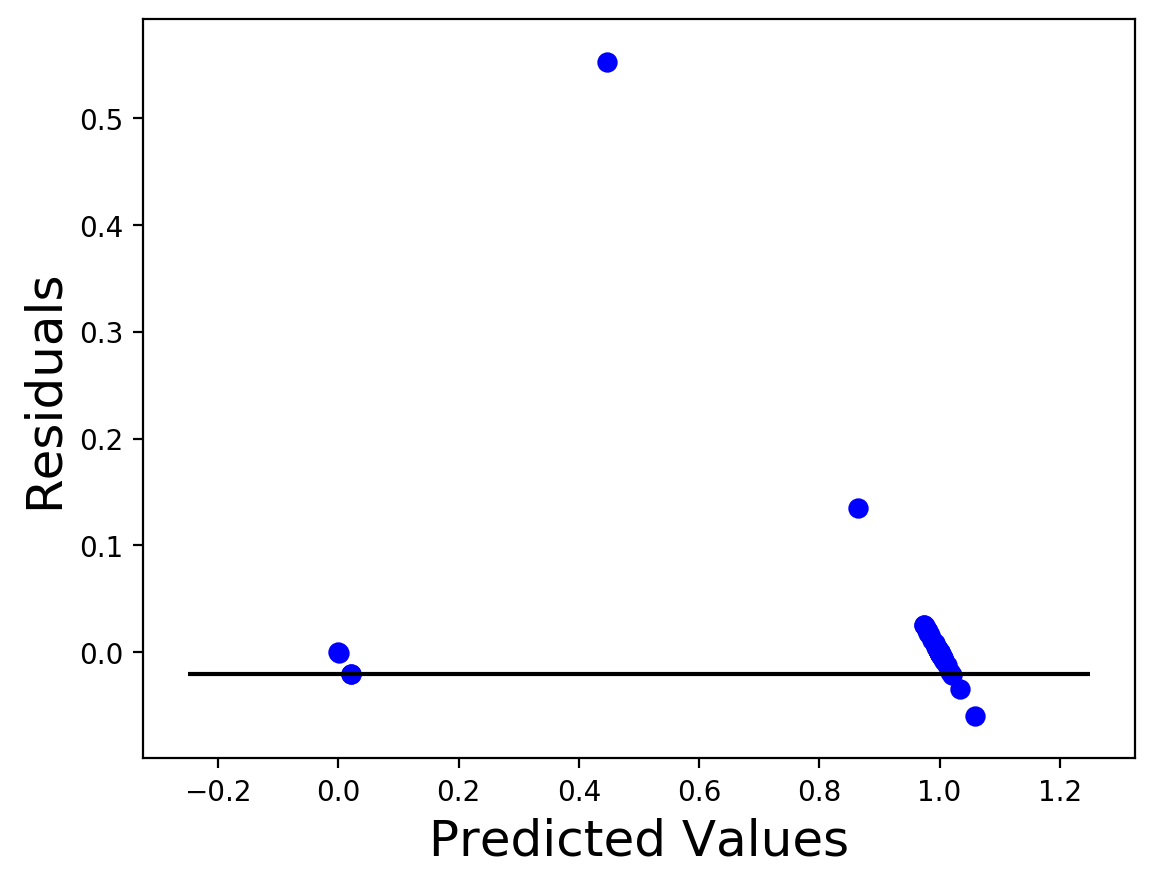

In [134]:
# Visualization: a residual plot to compare the model predictions and ground truth targets. 
# Binary results

residuals = ground_truth_label.values[:, 0] - model_predictions
plt.scatter(model_predictions, residuals, color="blue", s=40)
plt.hlines(y=-0.02, xmin=-0.25, xmax=1.25)
plt.xlabel("Predicted Values", fontsize=18)
plt.ylabel("Residuals", fontsize=18)
plt.show()

#### Quantitative

In [135]:
# Evaluate the model predictions quantitatively.
eval_r2_score = r2_score(ground_truth_label.values, model_predictions)
eval_mse_score = mean_squared_error(ground_truth_label.values, model_predictions)
eval_mae_score = mean_absolute_error(ground_truth_label.values, model_predictions)
print(
    f"{bold}Evaluation result on test data{unbold}:{newline}"
    f"{bold}{r2_score.__name__}{unbold}: {eval_r2_score}{newline}"
    f"{bold}{mean_squared_error.__name__}{unbold}: {eval_mse_score}{newline}"
    f"{bold}{mean_absolute_error.__name__}{unbold}: {eval_mae_score}{newline}"
)

Evaluation result on test data:
r2_score: 0.9111131505823139
mean_squared_error: 0.0049210712480379825
mean_absolute_error: 0.01730402212791994



### Delete SageMaker Endpoint

In [136]:
# Delete the SageMaker endpoint and the attached resources
predictor.delete_model()
predictor.delete_endpoint()

INFO:sagemaker:Deleting model with name: sagemaker-jumpstart-2023-04-17-02-38-07-750
INFO:sagemaker:Deleting endpoint configuration with name: clsm-train-xgboost-regression-model--2023-04-17-02-38-07-750
INFO:sagemaker:Deleting endpoint with name: clsm-train-xgboost-regression-model--2023-04-17-02-38-07-750


# XGBoost Metrics

In [137]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, roc_curve

In [138]:
# Target values = Test dataset AML Detected 

target = ground_truth_label.values[:, 0] 
print(target)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1]


In [139]:
# Test dataset Predicted values 

pred = (model_predictions> 0.5).astype(np.float32)
print(pred)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]


In [140]:
#Cross Validation

ALM_detected = ['no', 'yes']
print('Cross Validation: \n', 
      classification_report(target, pred, target_names=ALM_detected))

Cross Validation: 
               precision    recall  f1-score   support

          no       0.80      1.00      0.89         4
         yes       1.00      0.98      0.99        64

    accuracy                           0.99        68
   macro avg       0.90      0.99      0.94        68
weighted avg       0.99      0.99      0.99        68



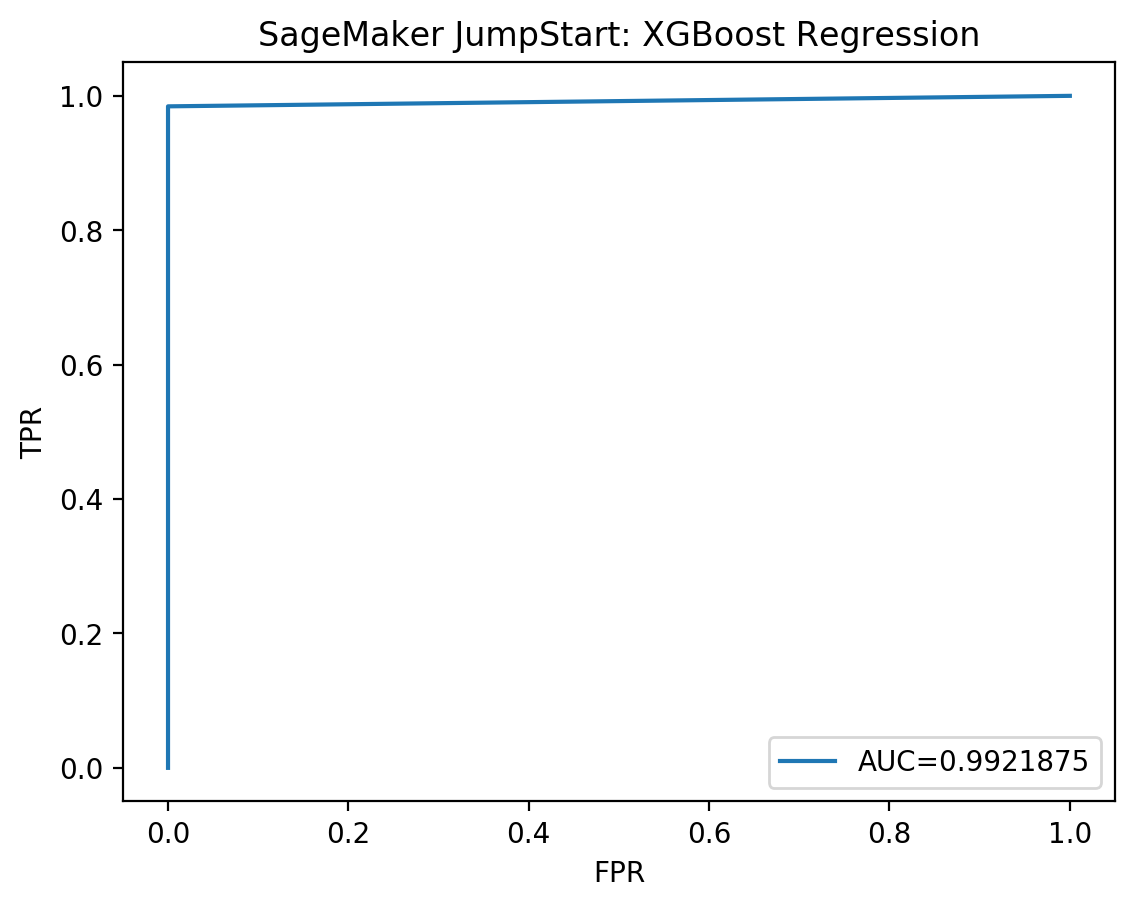

In [141]:
#ROC curve for SageMaker JumpStart: XGBoost Regression
fpr, tpr, _ = metrics.roc_curve(target,  pred)
auc = metrics.roc_auc_score(target, pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend(loc=4)
plt.title('SageMaker JumpStart: XGBoost Regression')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Release Resources

In [142]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [143]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>

# References

AWS SageMaker. Jumpstart. SGBoost Regression Model. SageMaker Built-In Algorithms: Tabular Regression using XGBoost and Linear Learner